# Описание проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса. <br>
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. <br>
У нас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. <br>
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник. <br>
Наша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании. <br>


In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap
import warnings

from sklearn.impute import SimpleImputer
# Импорт для масштабирования и кодирования данных
from sklearn.preprocessing import (
    # Масштабирование числовых значений
    StandardScaler,
    RobustScaler,
    MinMaxScaler,

    # Кодирование категориальных значений
    OneHotEncoder,
    LabelEncoder,
    OrdinalEncoder,
)

# Импорт линейных моделей
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    Lasso,
    Ridge,
)

from sklearn.dummy import (
    DummyClassifier,
    DummyRegressor
)

# Импорт метода опорных векторов
from sklearn.svm import SVC

# Импорт дерева решений
from sklearn.tree import (
    DecisionTreeClassifier,
    DecisionTreeRegressor
)

# Импорт метода ближайших соседей
from sklearn.neighbors import KNeighborsClassifier

# Импорт для подбора гиперпараметров модели и разбиения на выборки
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV
)

# Импорт для расчета метрик
from sklearn.metrics import (
    roc_auc_score,
    make_scorer
)

# Импорт для отбора признаков
from sklearn.feature_selection import (
    SelectKBest,
    f_classif,
)

# Импорт для создания пайплайнов
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

warnings.filterwarnings('ignore')
# pd.options.display.float_format = '{:,.1f}'.format

## Задача №1:

Предсказание уровня удовлетворённости сотрудника

Для этой задачи заказчик предоставил данные с признаками:
 - `id` — уникальный идентификатор сотрудника;
 - `dept` — отдел, в котором работает сотрудник;
 - `level` — уровень занимаемой должности;
 - `workload` — уровень загруженности сотрудника;
 - `employment_years` — длительность работы в компании (в годах);
 - `last_year_promo` — показывает, было ли повышение за последний год;
 - `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
 - `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
 - `salary` — ежемесячная зарплата сотрудника;
 - `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, *целевой признак*.


Данные:
 - Тренировочная выборка: `train_job_satisfaction_rate.csv`
 - Входные признаки тестовой выборки: `test_features.csv`
 - Целевой признак тестовой выборки: `test_target_job_satisfaction_rate.csv`


### Загрузка данных

Загрузим данные и выведем информацию о них

In [2]:
try:
    train_satisfaction_rate = pd.read_csv('data/first_task/train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('data/first_task/test_features.csv')
    test_target_satisfaction_rate = pd.read_csv('data/first_task/test_target_job_satisfaction_rate.csv')
except:
    train_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('/datasets/test_features.csv')
    test_target_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [3]:
train_satisfaction_rate = train_satisfaction_rate.sort_values('id')
print(train_satisfaction_rate.info())
train_satisfaction_rate.head()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 560 to 3757
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 343.8+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
560,100954,purchasing,junior,low,1,no,no,4,15600,0.60
1124,101057,sales,junior,low,1,no,yes,4,19200,0.45
1509,101074,sales,junior,medium,2,no,no,2,20400,0.36
2106,101081,sales,middle,low,2,no,no,4,28800,0.66
405,101129,technology,junior,medium,1,no,no,4,34800,0.71


In [4]:
test_features = test_features.sort_values('id')
print(test_features.info())
test_features.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 1172 to 1844
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 156.2+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,no,no,4,19200
852,100480,marketing,junior,low,4,no,no,4,16800
848,100503,purchasing,middle,high,5,no,no,4,55200
524,100610,sales,middle,medium,5,no,no,4,43200
476,100692,sales,middle,high,6,no,no,4,48000


In [5]:
test_target_satisfaction_rate = test_target_satisfaction_rate.sort_values('id')
print(test_target_satisfaction_rate.info())
test_target_satisfaction_rate.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 1734 to 334
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 46.9 KB
None


,id,job_satisfaction_rate
1734,100298,0.80
1467,100480,0.84
190,100503,0.79
60,100610,0.75
231,100692,0.69


Мы видим, что у нас есть пара пропусков в таблице для обучения и в таблице с тестовыми данными. Заполним их позже модой, используя пайплайн

### Предобработка данных:

Ранее мы уже увидели, что у нас есть пару пропусков в таблицах. Посмотрим, какие у нас названия столбцов, уникальные значения категориальных значений

In [6]:
cat_col_names = train_satisfaction_rate.select_dtypes(exclude=['number']).columns.tolist()

for col in cat_col_names:
    print(col, ':', train_satisfaction_rate[col].unique())
    print()

dept : ['purchasing' 'sales' 'technology' 'hr' 'marketing' nan]

level : ['junior' 'middle' 'sinior' nan]

workload : ['low' 'medium' 'high']

last_year_promo : ['no' 'yes']

last_year_violations : ['no' 'yes']



In [7]:
for col in cat_col_names:
    print(col, ':', test_features[col].unique())
    print()

dept : ['hr' 'marketing' 'purchasing' 'sales' 'technology' nan ' ']

level : ['junior' 'middle' 'sinior' nan]

workload : ['low' 'high' 'medium' ' ']

last_year_promo : ['no' 'yes']

last_year_violations : ['no' 'yes']



Мы видим, что у нас различаются значения в столбцах `dept` и `workload`. У нас присутствует пробел. Заменим их на `np.nan`, чтобы корректно провести исследовательский анализ данных. Тем не менее добавим позже в пайплайн обработку неизвестных значений

In [8]:
# Заменяем пробел на пропуск
test_features['dept'] = test_features['dept'].replace(' ', np.nan)
test_features['workload'] = test_features['workload'].replace(' ', np.nan)

train_satisfaction_rate['level'] = train_satisfaction_rate['level'].replace('sinior', 'senior')
test_features['level'] = test_features['level'].replace('sinior', 'senior')

# Проверяем, корректно ли у нас все заменилось
for col in cat_col_names:
    print(f'Тренировочный датафрейм, столбец: {col}:{train_satisfaction_rate[col].unique()}')
    print(f'Тестовый датафрейм, столбец: {col}:{(test_features[col].unique())}\n')
    print()

Тренировочный датафрейм, столбец: dept:['purchasing' 'sales' 'technology' 'hr' 'marketing' nan]
Тестовый датафрейм, столбец: dept:['hr' 'marketing' 'purchasing' 'sales' 'technology' nan]


Тренировочный датафрейм, столбец: level:['junior' 'middle' 'senior' nan]
Тестовый датафрейм, столбец: level:['junior' 'middle' 'senior' nan]


Тренировочный датафрейм, столбец: workload:['low' 'medium' 'high']
Тестовый датафрейм, столбец: workload:['low' 'high' 'medium' nan]


Тренировочный датафрейм, столбец: last_year_promo:['no' 'yes']
Тестовый датафрейм, столбец: last_year_promo:['no' 'yes']


Тренировочный датафрейм, столбец: last_year_violations:['no' 'yes']
Тестовый датафрейм, столбец: last_year_violations:['no' 'yes']




In [9]:
test_features.isna().sum()

id                       0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Посмотрим на наличие явных дубликатов

In [10]:
print(train_satisfaction_rate.duplicated().sum())
print(test_features.duplicated().sum())

0
0


#### Промежуточный вывод:

Во время предобработки данных мы обнаружили, что в таблице `test_features` в некоторых категориальных столбцах присутствуют пробел вместо значений. Мы заменили их на `np.nan`, которые впоследствии будут обработаны с помощью пайплайна. После замены, у нас появилось всего пара пропусков. Скорее всего это обосновано человеческим фактором, или же программной проблемой. Так же исправили опечатку

### Исследовательский анализ данных
Проведем исследовательский анализ данных: Посмотрим на то как распределены числовые и категориальные значение

#### Анализ числовых значений

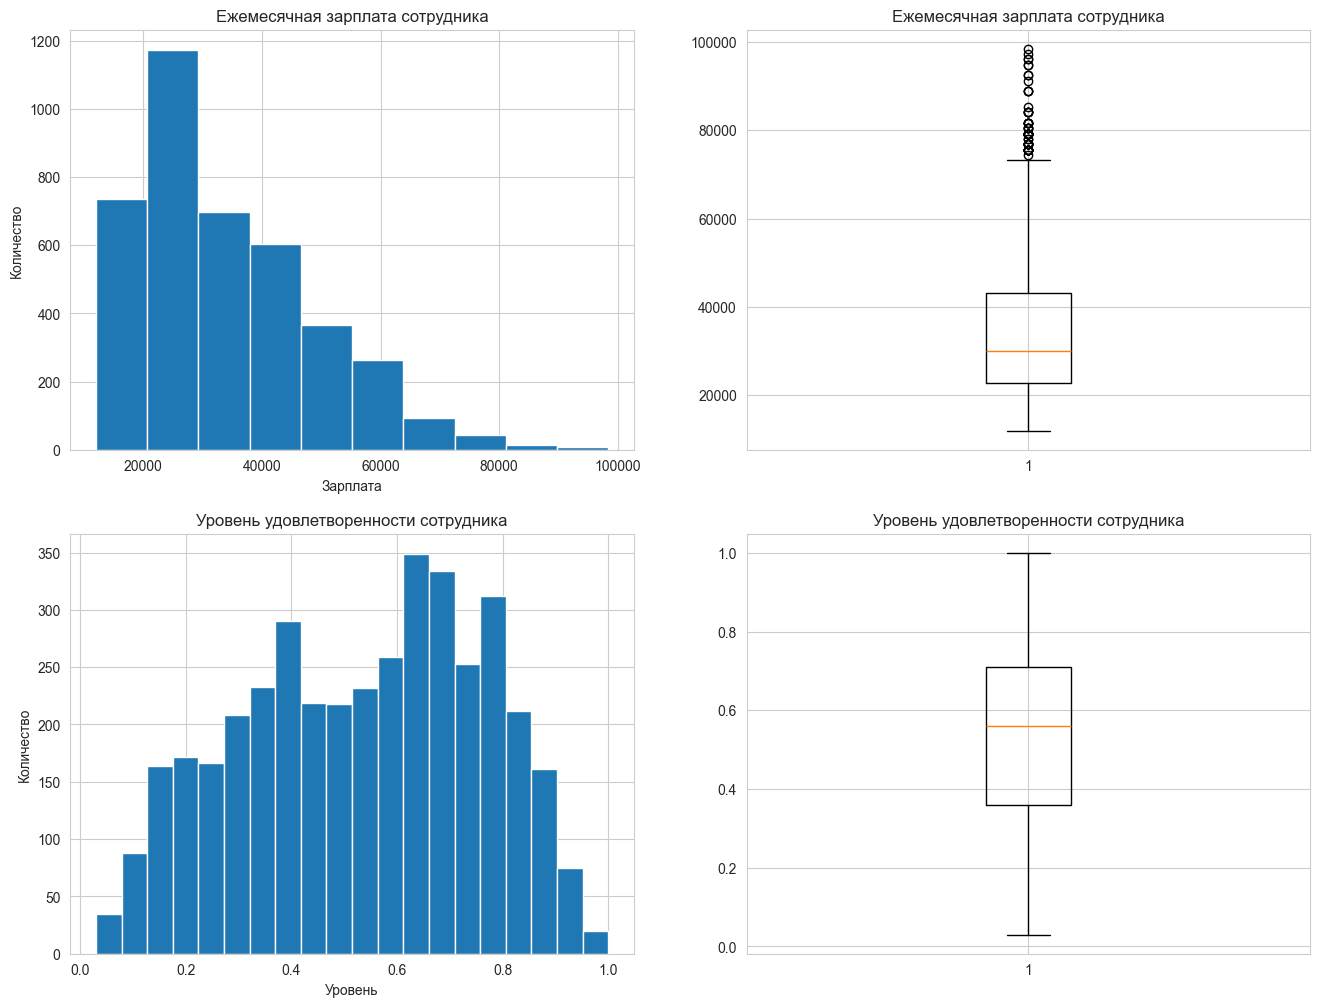

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Зарплата
ax[0, 0].hist(train_satisfaction_rate['salary'], bins=10)
ax[0, 0].set_xlabel('Зарплата')
ax[0, 0].set_ylabel('Количество')
ax[0, 0].set_title('Ежемесячная зарплата сотрудника')

ax[0, 1].boxplot(train_satisfaction_rate['salary'])
ax[0, 1].set_title('Ежемесячная зарплата сотрудника')

# Уровень удовлетворенности
ax[1, 0].hist(train_satisfaction_rate['job_satisfaction_rate'], bins=20)
ax[1, 0].set_xlabel('Уровень')
ax[1, 0].set_ylabel('Количество')
ax[1, 0].set_title('Уровень удовлетворенности сотрудника')

ax[1, 1].boxplot(train_satisfaction_rate['job_satisfaction_rate'])
ax[1, 1].set_title('Уровень удовлетворенности сотрудника')

plt.show()

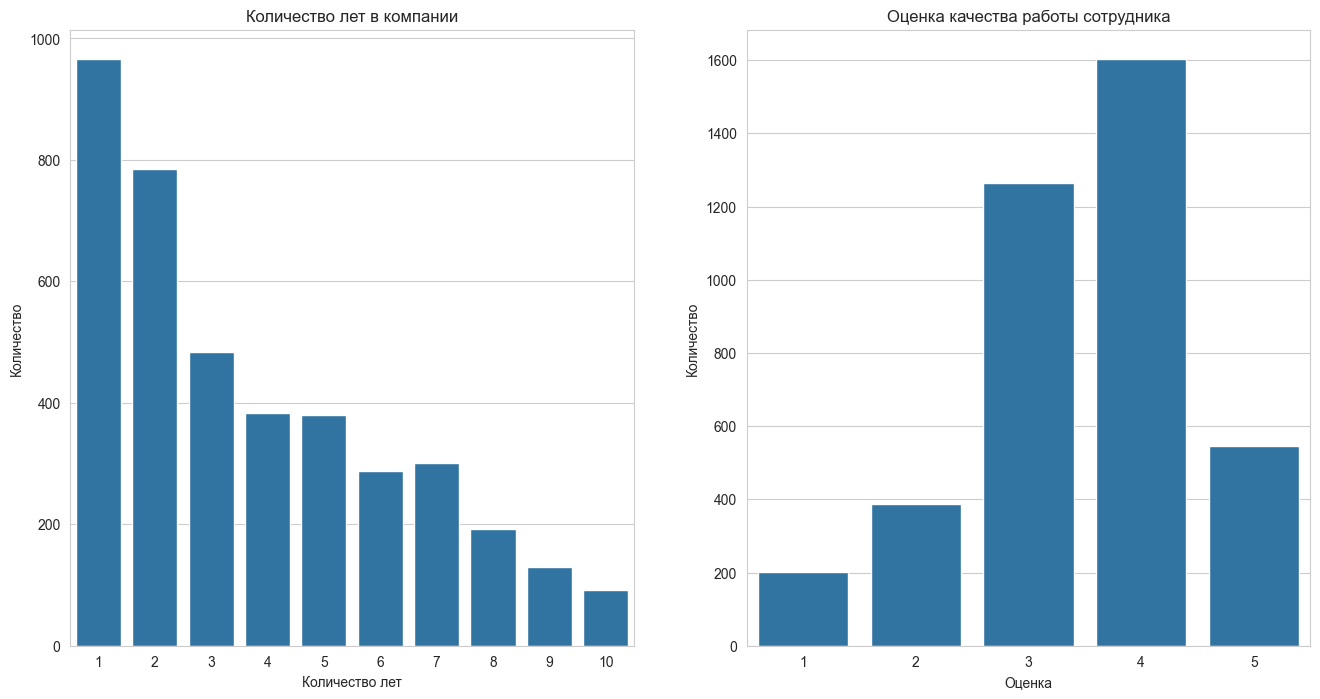

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Количество лет в компании
sns.countplot(train_satisfaction_rate, x='employment_years', ax=ax[0])
ax[0].set_xlabel('Количество лет')
ax[0].set_ylabel('Количество')
ax[0].set_title('Количество лет в компании')

# Оценка качества работы сотрудника
sns.countplot(train_satisfaction_rate, x='supervisor_evaluation', ax=ax[1])
ax[1].set_xlabel('Оценка')
ax[1].set_ylabel('Количество')
ax[1].set_title('Оценка качества работы сотрудника')

plt.show()

Мы видим, что в столбце с оценкой сотрудника есть выброс, при которой оценка составляет 1. Это допустимая оценка, но рассмотрим этот момент детальнее. Остальные выбросы не представляют проблем, потому что они реалистичны, а значит модель не будет обучаться в "идеальных условиях".

В остальных данных у нас нет особо никаких проблем. В компании довольно много людей, которые работают там недавно, так как в гистограмме со сроком работы, присутствует выраженный выброс около нуля. Распределение удовлетворенности почти равномерное, с небольшим смещением к 0.6

In [13]:
print('Количество работников, качество которых было оценено как 1:',
      train_satisfaction_rate[train_satisfaction_rate['supervisor_evaluation'] == 1]['job_satisfaction_rate'].count())

print('Медианный уровень удовлетворенности:',
      train_satisfaction_rate[train_satisfaction_rate['supervisor_evaluation'] == 1]['job_satisfaction_rate'].median())

Количество работников, качество которых было оценено как 1: 201
Медианный уровень удовлетворенности: 0.31


Всего у нас 201 сотрудник, которыми работодатель недоволен. Сотрудники же в свою очередь тоже не очень довольны, потому что их медианный уровень удовлетворенности составляет всего `0.31`.

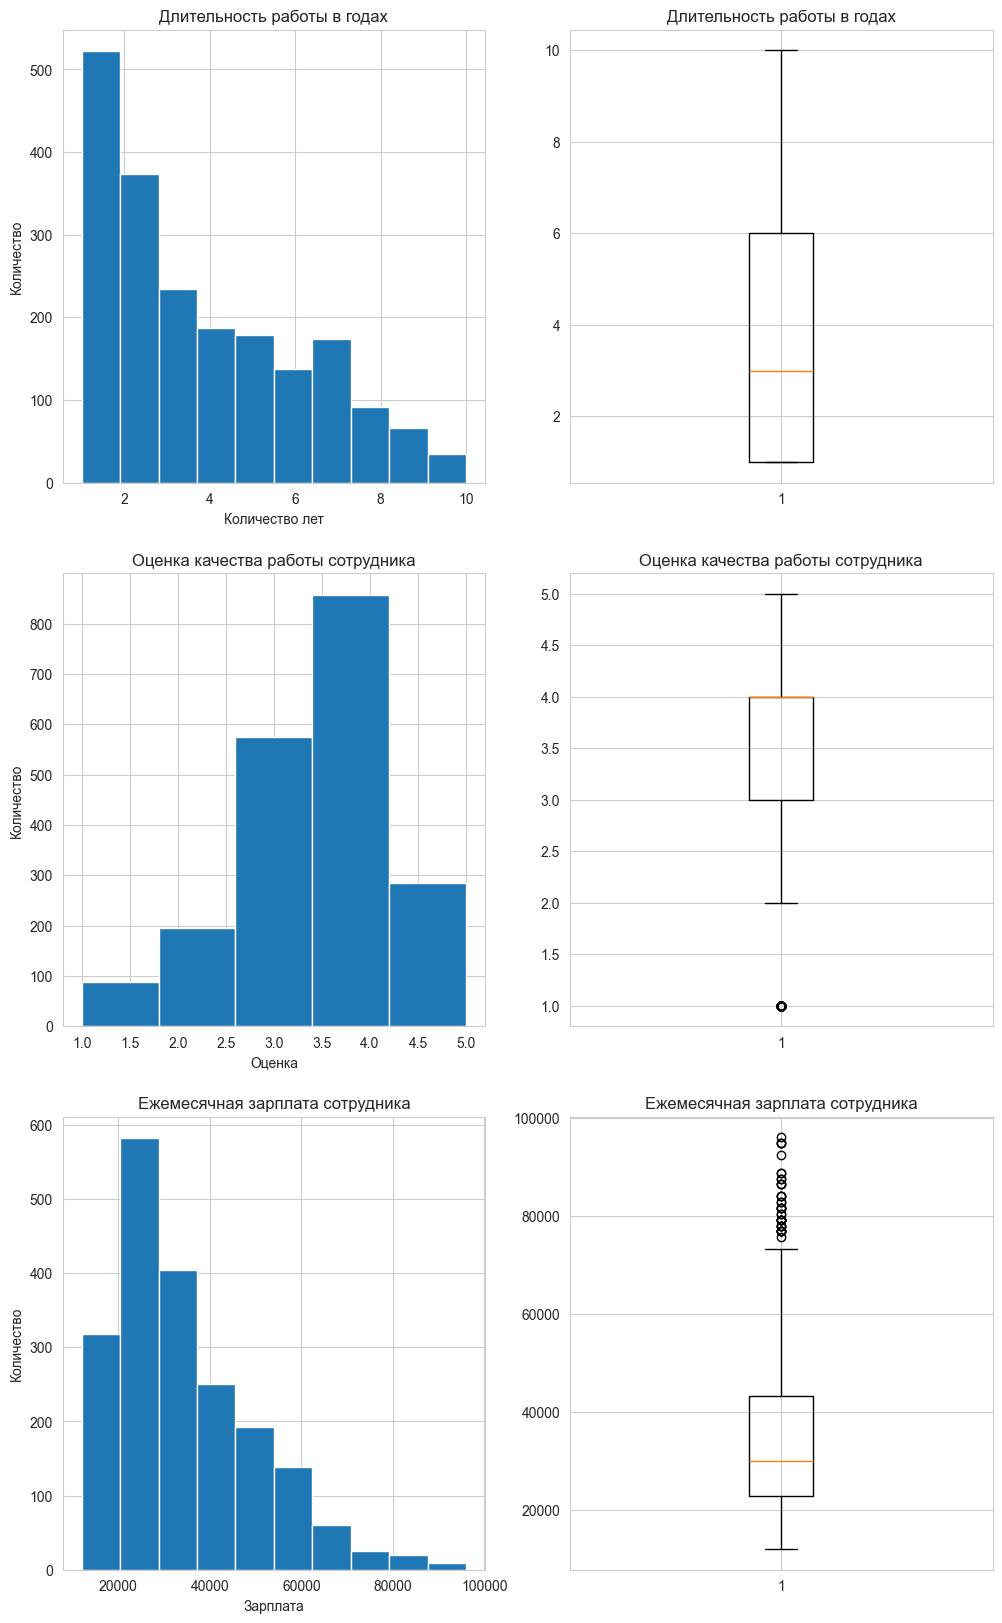

In [14]:
# Посмотрим на то, как распределены данные в тестовых данных
fig, ax = plt.subplots(3, 2, figsize=(12, 20))

# Длительность работы
ax[0, 0].hist(test_features['employment_years'], bins=10)
ax[0, 0].set_xlabel('Количество лет')
ax[0, 0].set_ylabel('Количество')
ax[0, 0].set_title('Длительность работы в годах')

ax[0, 1].boxplot(test_features['employment_years'])
ax[0, 1].set_title('Длительность работы в годах')

# Оценка качества работы сотрудника
ax[1, 0].hist(test_features['supervisor_evaluation'], bins=5)
ax[1, 0].set_xlabel('Оценка')
ax[1, 0].set_ylabel('Количество')
ax[1, 0].set_title('Оценка качества работы сотрудника')

ax[1, 1].boxplot(test_features['supervisor_evaluation'])
ax[1, 1].set_title('Оценка качества работы сотрудника')

# Зарплата
ax[2, 0].hist(test_features['salary'], bins=10)
ax[2, 0].set_xlabel('Зарплата')
ax[2, 0].set_ylabel('Количество')
ax[2, 0].set_title('Ежемесячная зарплата сотрудника')

ax[2, 1].boxplot(test_features['salary'])
ax[2, 1].set_title('Ежемесячная зарплата сотрудника')

plt.show()

В принципе данные почти не отличаются от тренировочных, выбросов нет, распределения похожи. Можно разве что отметить, что количество новых сотрудников там чуть больше.

#### Анализ категориальных значений

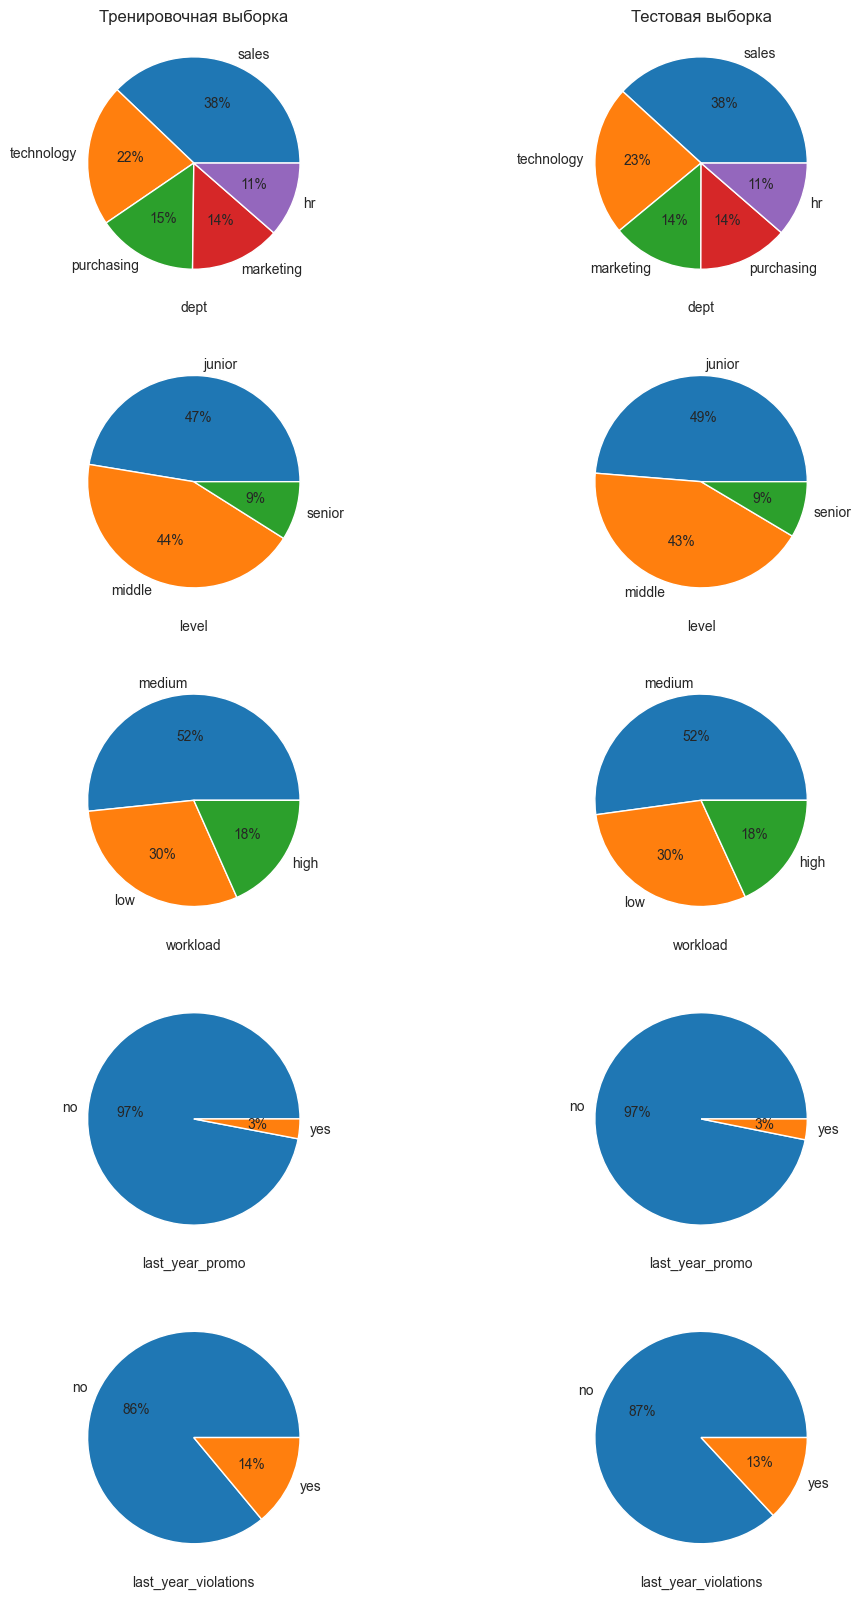

In [15]:
# Посмотрим распределение категориальных значений в тренировочной и тестовой выборках
fig, ax = plt.subplots(5, 2, figsize=(12, 20))

for i in range(len(cat_col_names)):
    ax[i, 0].pie(
        train_satisfaction_rate[cat_col_names[i]].value_counts(),
        labels=train_satisfaction_rate[cat_col_names[i]].value_counts().index,
        autopct='%1.0f%%',
    )
    ax[i, 0].set_xlabel(cat_col_names[i])

    ax[i, 1].pie(
        test_features[cat_col_names[i]].value_counts(),
        labels=test_features[cat_col_names[i]].value_counts().index,
        autopct='%1.0f%%',
    )
    ax[i, 1].set_xlabel(cat_col_names[i])

ax[0, 0].set_title('Тренировочная выборка')
ax[0, 1].set_title('Тестовая выборка')
plt.show()

Мы видим, что у распределения категориальных значений у нас почти идентично в тренировочной и тестовой выборках. На пару процентов больше "junior-разработчиков". Как раз объясняет выброс около нуля в столбце "employment_years". У нас присутствует дисбаланс классов, однако использовать OverSampling или UnderSampling будет нецелесообразно, потому как данные в таблице представляют положение дел в компании, и дисбаланс классов объяснен логически. Очевидно, что разработчиков уровня "senior" в разы меньше, чем разработчиков иных уровней. OverSampling или UnderSampling было бы разумно использовать в том случае, если бы конкретно в тренировочной выборке был дисбаланс классов из-за условий создания этой выборки. То есть к примеру, опрос проводили преимущественно среди разработчиков уровня middle и senior, и тогда бы у нас был малый процент junior-разработчиков. Оставим все как есть.

Создадим сводную таблицу и посмотрим, как данные распределяются по уровню занимаемой должности `level`

In [16]:
# Сразу выводим сводную таблицу, потому что позже она нам не понадобиться
train_satisfaction_rate.pivot_table(index='level',
                                    values=['workload', 'employment_years', 'supervisor_evaluation', 'salary',
                                            'job_satisfaction_rate'],
                                    aggfunc={
                                        'workload': lambda x: x.mode()[0],  # Функция для получения моды
                                        'employment_years': 'median',
                                        'supervisor_evaluation': 'median',
                                        'salary': 'median',
                                        'job_satisfaction_rate': 'median',
                                    })

,employment_years,job_satisfaction_rate,salary,supervisor_evaluation,workload
level,,,,,
junior,2.0,0.55,24000.0,4.0,medium
middle,5.0,0.58,39600.0,4.0,medium
senior,6.0,0.54,56400.0,4.0,medium


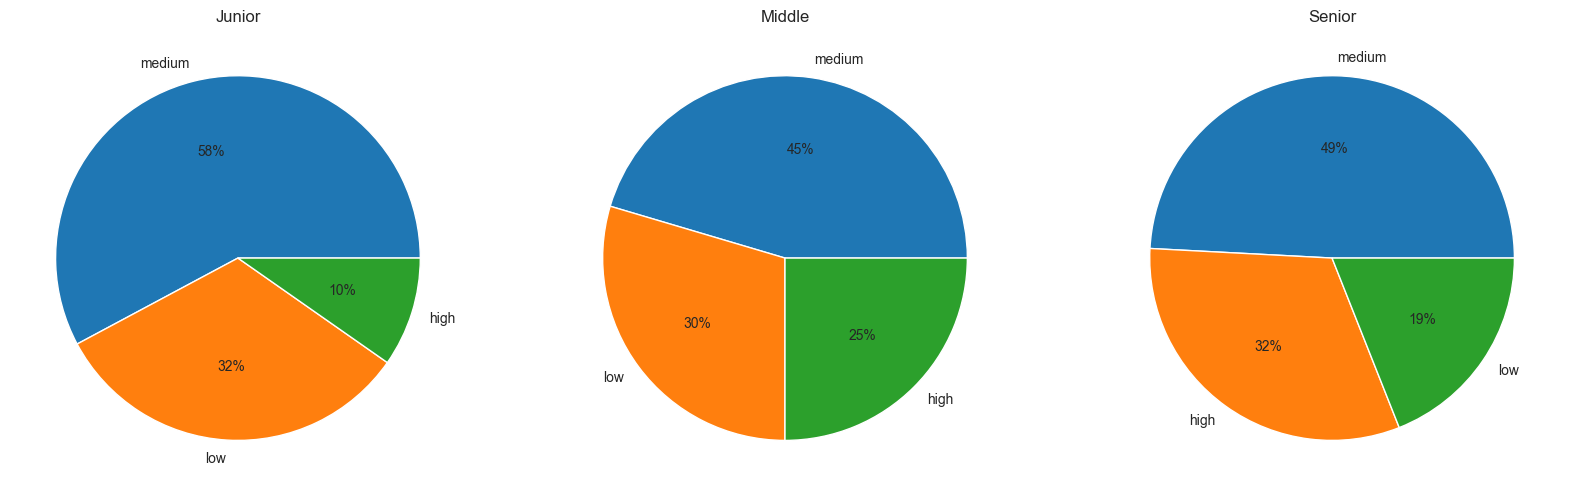

In [17]:
# Посмотрим, как нагрузка распределена по уровням сотрудников
fig, ax = plt.subplots(1, 3, figsize=(20, 8))

ax[0].pie(
    train_satisfaction_rate.loc[train_satisfaction_rate['level'] == 'junior', 'workload'].value_counts(),
    labels=train_satisfaction_rate.loc[train_satisfaction_rate['level'] == 'junior', 'workload'].value_counts().index,
    autopct='%1.0f%%',
)
ax[0].set_title('Junior')

ax[1].pie(
    train_satisfaction_rate.loc[train_satisfaction_rate['level'] == 'middle', 'workload'].value_counts(),
    labels=train_satisfaction_rate.loc[train_satisfaction_rate['level'] == 'middle', 'workload'].value_counts().index,
    autopct='%1.0f%%',
)
ax[1].set_title('Middle')

ax[2].pie(
    train_satisfaction_rate.loc[train_satisfaction_rate['level'] == 'senior', 'workload'].value_counts(),
    labels=train_satisfaction_rate.loc[train_satisfaction_rate['level'] == 'senior', 'workload'].value_counts().index,
    autopct='%1.0f%%',
)
ax[2].set_title('Senior')

plt.show()

Что сотрудники уровня "junior" в основном получают среднюю нагрузку, в то время как сотрудники уровня "senior" больше остальных получают высокую нагрузку.

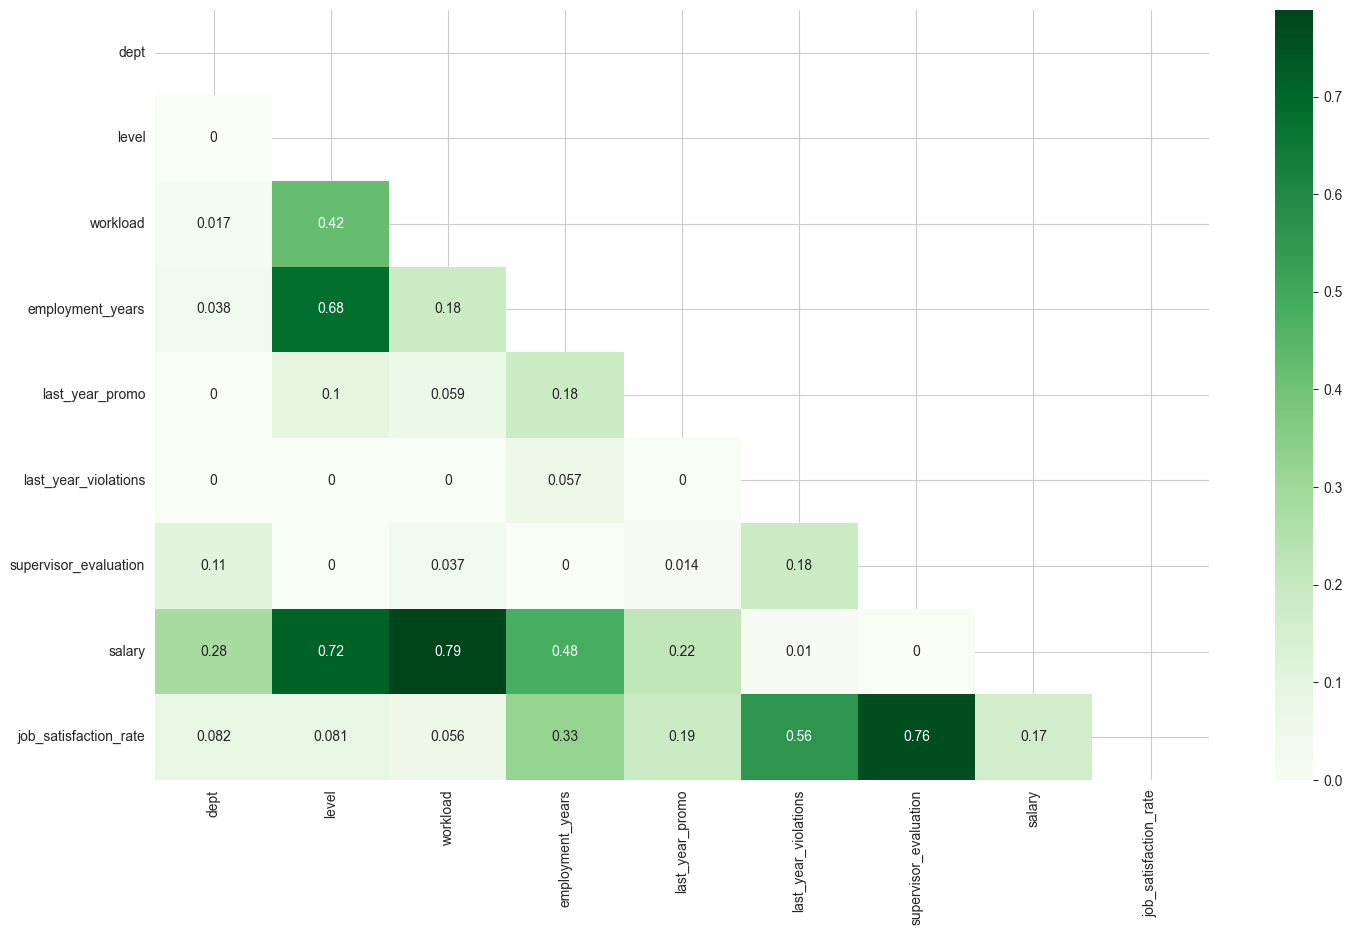

In [18]:
# Создадим хитмап корреляции для тренировочной выборки
plt.figure(figsize=(17, 10))

sns.heatmap(
    train_satisfaction_rate.drop('id', axis=1).phik_matrix(
        interval_cols=['job_satisfaction_rate', 'salary'],
    ),
    annot=True, cmap='Greens',
    mask=(np.triu(np.ones_like(
        train_satisfaction_rate.drop('id', axis=1).phik_matrix(interval_cols=['job_satisfaction_rate', 'salary']),
        dtype=bool)))
)

plt.show()

Зарплата — признак, который больше всех коррелирует со всеми остальными. Мы видим, что зарплата очень сильно коррелирует с нагрузкой и уровнем сотрудника. Так же есть корреляция с длительностью работы в компании. Так же мы видим высокую коллинеарность между уровнем удовлетворения сотрудника компанией и уровнем удовлетворения компании сотрудником. Логично предположить, что чем меньше сотруднику нравится компания, тем хуже он выполняет работу и тем меньше компания оценивает этого сотрудника.

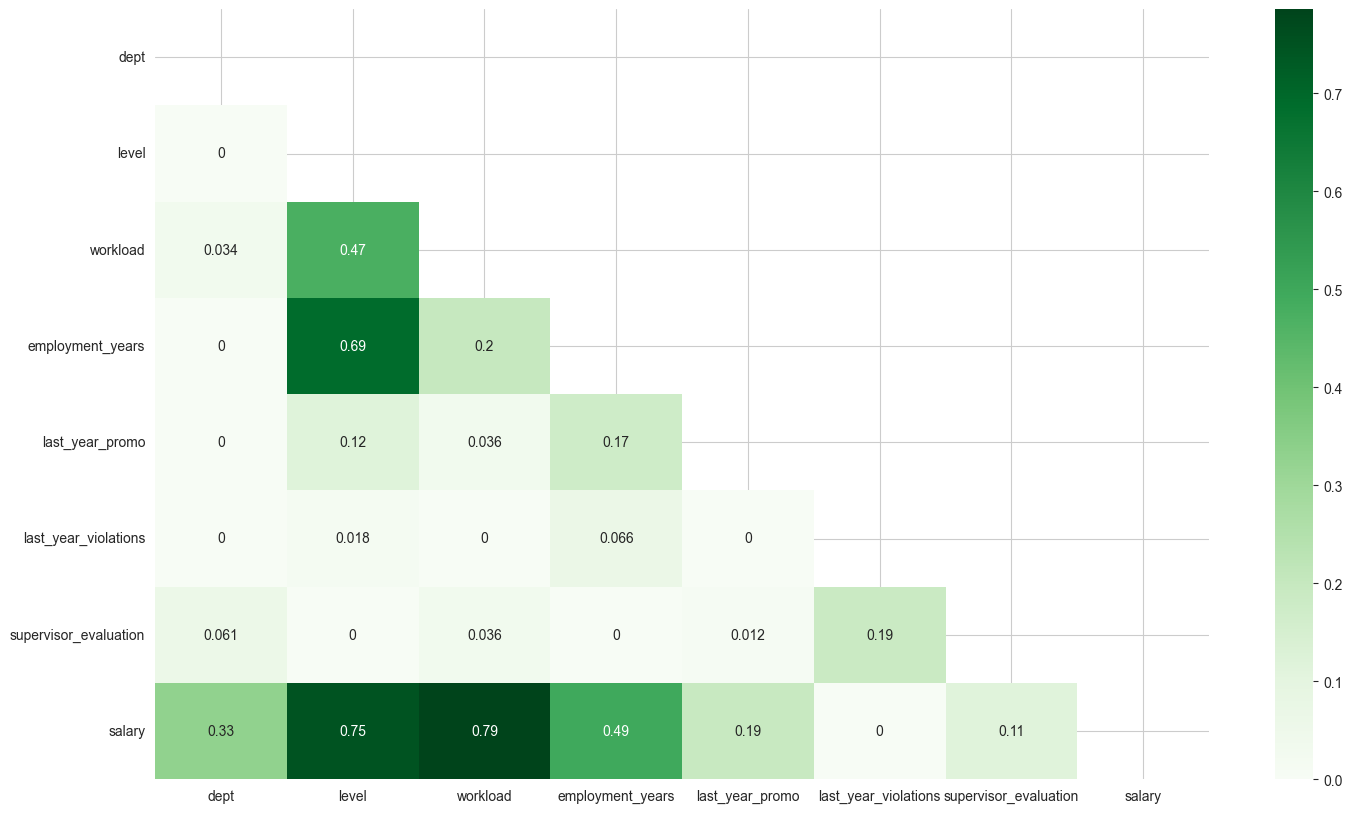

In [19]:
# Создадим хитмап корреляции для тестовой выборки
plt.figure(figsize=(17, 10))

sns.heatmap(
    test_features.drop('id', axis=1).phik_matrix(
        interval_cols=['salary'],
    ),
    annot=True, cmap='Greens',
    mask=(np.triu(np.ones_like(
        test_features.drop('id', axis=1).phik_matrix(interval_cols=['salary']),
        dtype=bool)))
)

plt.show()

Корреляци данных в тестовой выборке почти не отличаются от корреляции в тренировочной выборке

#### Промежуточный вывод:

В числовых значениях у нас все отлично, скорее всего, это внутренние данные, потому они уже предобработаны. В компании довольно много людей, которые работают там недавно, так как в гистограмме со сроком работы, присутствует выраженный выброс около нуля. Распределение удовлетворенности почти равномерное, с небольшим смещением к 0.6

Мы заметили дисбаланс классов, однако мы решили не использовать никакую из технологий сэмплинга, чтобы устранить дисбаланс. Такое решение было принято потому что в противном случае мы бы исказили данные, нарушив "положение дел" в компании

Медианный уровень удовлетворенности примерно одинаковый для каждого уровня сотрудников.

Зарплата — признак, который больше всех коррелирует со всеми остальными. Мы видим, что зарплата очень сильно коррелирует с нагрузкой и уровнем сотрудника. Так же есть корреляция с длительностью работы в компании. Так же мы видим высокую коллинеарность между уровнем удовлетворения сотрудника компанией и уровнем удовлетворения компании сотрудником. Логично предположить, что чем меньше сотруднику нравится компания, тем хуже он выполняет работу и тем меньше компания оценивает этого сотрудника. Этот признак мультиколлинеарен

Всего у нас 201 сотрудник, которыми работодатель недоволен. Эти сотрудники же в свою очередь тоже не очень довольны, потому что их медианный уровень удовлетворенности составляет всего `0.31`.

### Подготовка данных
Подготовим данные, используя пайплайн. Для этого создадим его, выделим категориальные, ординальные, и числовые значения

In [20]:
# Смотрим, является ли у нас столбец supervisor_evaluation числовым, или ординальным
train_satisfaction_rate['supervisor_evaluation'].unique()

array([4, 2, 5, 3, 1])

In [21]:
num_columns = ['employment_years', 'salary']
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']

In [22]:
# Пайплайн для числовых значений
num_pipeline = Pipeline(
    [
        (
            'imputer_before_scaler',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
        ),
        (
            'num',
            StandardScaler()
        ),
    ]
)

In [23]:
# Папйплайн для категориальных значений
ohe_pipeline = Pipeline(
    [
        (
            'imputer_before_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
        ),

    ]
)

In [24]:
# Папйплайн для ординальных значений
ord_pipeline = Pipeline(
    [
        (
            'imputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
        ),
        (
            'ord',
            OrdinalEncoder(handle_unknown='use_encoded_value',
                           unknown_value=np.nan,
                           categories=[
                               ['junior', 'middle', 'senior'],
                               ['low', 'medium', 'high'],
                               # [1, 2, 3, 4, 5]
                           ])
        ),
        (
            'imputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
        ),
    ]
)

In [25]:
# Собираем в один пайплайн по подготовке данных
data_preprocessor = ColumnTransformer(
    [
        ('num', num_pipeline, num_columns),
        ('ohe', ohe_pipeline, ohe_columns),
        ('ord', ord_pipeline, ord_columns),
    ],
    remainder='passthrough',
)

#### Промежуточный вывод:

Мы создали пайплайн для предобработки данных. Все выбивающиеся значения (как, например, пробелы) и пропуски будут заменяться на самое часто встречаемое значение.

### Обучение модели

Создадим пайплайн, который будет содержать в себе пайплайн по предобработке данных, и обучение модели на этих данных. Так как ранее мы выявили, что зарплата мультиколленеарна, то используем еще модели, которые устойчивы к мультиколлинеарности: `LASSO` и `Ridge`

In [26]:
# Смотрим на количество явных дубликатов после удаления id
X_satisfaction = train_satisfaction_rate.drop(columns=['id'], axis=1)

X_satisfaction.duplicated().sum()

np.int64(245)

In [27]:
# Удаляем явные дубликаты
X_satisfaction = X_satisfaction.drop_duplicates()
X_satisfaction.duplicated().sum()

np.int64(0)

In [28]:
RANDOM_STATE = 42

y_satisfaction = X_satisfaction['job_satisfaction_rate']
X_satisfaction = X_satisfaction.drop(columns=['job_satisfaction_rate'], axis=1)

X_test = test_features.drop(columns=['id'], axis=1)
y_test = test_target_satisfaction_rate['job_satisfaction_rate']

In [29]:
# Создадим свою функцию оценки качества модели
def count_smape_score(y_true, y_pred):
    return (100 / len(y_true)) * np.sum(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))


smape_score = make_scorer(count_smape_score, greater_is_better=False)

In [30]:
# Собираем в конечный пайплайн
final_linear_pipeline = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DummyRegressor(strategy='median')),
    ]
)

In [31]:
# Создаем сетку параметров
param_grid_reg = [
    # Словарь для линейной регрессии
    {
        'models': [LinearRegression()],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler()],
    },

    # Словарь для регрессионого дерева решений
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 50),
        'models__max_features': range(1, 50),
        'models__min_samples_leaf': range(1, 50),
        'models__min_samples_split': range(2, 50),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough'],
    },

    # Словарь для LASSO
    {
        'models': [Lasso(random_state=RANDOM_STATE)],
        'models__alpha': np.arange(0.01, 1, 0.1),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough'],
    },

    # Словарь для Ridge
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha': np.arange(0.01, 1, 0.1),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough'],
    }
]

In [32]:
random_search = RandomizedSearchCV(
    final_linear_pipeline,
    param_grid_reg,
    n_jobs=-1,
    cv=5,
    n_iter=100,
    scoring=smape_score,
    random_state=RANDOM_STATE,
)

random_search.fit(X_satisfaction, y_satisfaction)
print(-random_search.best_score_)
random_search.best_estimator_

15.400267318622785


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  ['employment_years',
                                                   'salary']),
                                                 ('ohe',
                                                  Pipeline(steps=[('imputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_viola...
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('imputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=24, max_features=39,
                                       min_samples_leaf=3, min_samples_split=9,
                                       random_state=42))])

In [33]:
y_test_pred = random_search.predict(X_test)
count_smape_score(np.array(y_test), y_test_pred)

np.float64(13.429246393742416)

In [34]:
best_model = random_search.best_estimator_


#### Промежуточный вывод:

Мы создали пайплайн для обучения модели. Для поиска наилучших гиперпараметров мы использовали `RandomizedSearchCV`.
Мы так же создали свою собственную метрику `symmetric mean absolute percentage error`, которая показывает, насколько процентов в среднем отклоняются предсказания.

Лучше всего сработала модель `DecisionTreeRegressor` со следующими параметрами:
 - max_depth=24
 - max_features=39
 - min_samples_leaf=3
 - min_samples_split=9

На тренировочной выборке мы получили значение метрики, равной 15.4%. На валидацонной и тестовых выборках мы получили значение в `14.6%` и `14.5%` соответственно. Это хорошее значение, так как значение меньше 15% можно считать успехом.


### Анализ важности признаков

Посмотрим, какие признаки вносят наибольший вклад в решение модели

In [35]:
X_train_shap = pd.DataFrame(
    final_linear_pipeline.named_steps['preprocessor'].fit_transform(X_satisfaction),
    columns=final_linear_pipeline.named_steps['preprocessor'].get_feature_names_out()
)

X_test_shap = pd.DataFrame(
    final_linear_pipeline.named_steps['preprocessor'].transform(X_test),
    columns=final_linear_pipeline.named_steps['preprocessor'].get_feature_names_out()
)

In [36]:
model = random_search.best_estimator_.named_steps['models']
model.fit(X_train_shap, y_satisfaction)

explainer = shap.TreeExplainer(model, X_train_shap)

shap_values = explainer(X_test_shap, check_additivity=False)

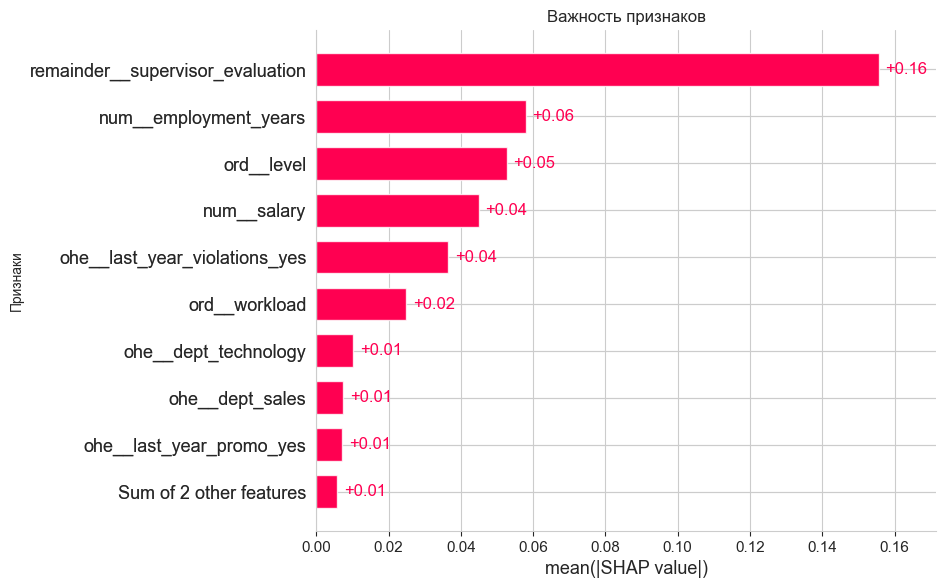

In [37]:
shap.plots.bar(shap_values, max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()

ax.set_ylabel('Признаки')
ax.set_title('Важность признаков')
plt.show()

Больше всего на предсказания модели влияют следующие признаки:
- `supervisor_evaluation` - оценка качества работы сотрудника, который дал работодатель
- `employment_years` - время работы в компании
- `level` - уровень занимаемой должности
- `salary` - ежемесячная зарплата сотрудника
- `last_year_violations` - оказывает, нарушал ли сотрудник трудовой договор за последний год
- `workload` - уровень загруженности сотрудника

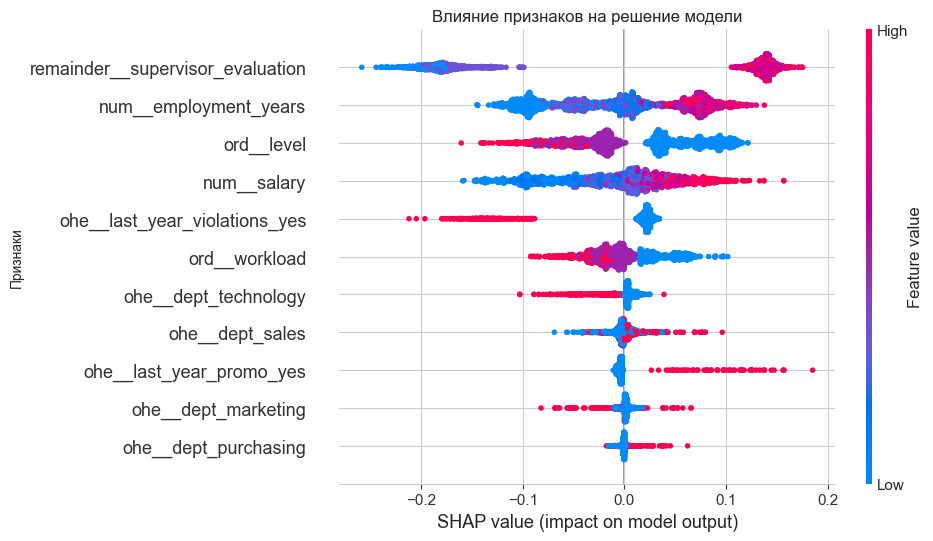

In [38]:
shap.plots.beeswarm(shap_values, max_display=15, show=False)
fig, ax = plt.gcf(), plt.gca()

ax.set_ylabel('Признаки')
ax.set_title('Влияние признаков на решение модели')
plt.show()

- `supervisor_evaluation` - чем меньше метрика, тем меньше целевой признак
- `employment_years` - чем больше время, проведенное в компании, тем больше его уровень удовлетворенности
- `level` - чем меньше уровень сотрудника, тем выше его удовлетворенность
- `salary` - чем выше зарплата, тем выше уровень удовлетворенности сотрудника
- `last_year_violations` - наличие нарушений с большей вероятностью понизит удовлетворенность сотрудника
- `workload` - чем меньше уровень загруженности сотрудника, тем больше его удовлетворенность


#### Промежуточный вывод:

Мы выделили 6 значений, которые больше всего влияют на уровень удовлетворенности сотрудника:
 - `supervisor_evaluation` - чем меньше метрика, тем меньше целевой признак
 - `employment_years` - чем больше время, проведенное в компании, тем больше его уровень удовлетворенности
 - `level` - чем меньше уровень сотрудника, тем выше его удовлетворенность
 - `salary` - чем выше зарплата, тем выше уровень удовлетворенности сотрудника
 - `last_year_violations` - наличие нарушений с большей вероятностью понизит удовлетворенность сотрудника
 - `workload` - чем меньше уровень загруженности сотрудника, тем больше его удовлетворенность

Стоит отметить, что признак `supervisor_evaluation` влияет больше всего, однако это признак, который не влияет напрямую на уровень удовлетворенности сотрудника. Скорее всего, это внутренняя информация компании, недоступная сотруднику. Тем не менее, если обучать модель без него, то качество модели ухудшается почти в 2 раза, и метрика составляет почти 30%.


### Вывод

Во время предобработки данных мы обнаружили, что в таблице `test_features` в некоторых категориальных столбцах присутствуют пробел вместо значений. Мы заменили их на `np.nan`.

Во время исследовательского анализа, мы обнаружили, что в числовых значениях у нас все отлично. В компании довольно много людей, которые работают там недавно, так как в гистограмме со сроком работы, присутствует выраженный выброс около нуля. Распределение удовлетворенности почти равномерное, с небольшим смещением к 0.6

Мы заметили дисбаланс классов, однако мы решили не использовать никакую из технологий сэмплинга, чтобы устранить дисбаланс. Такое решение было принято потому что в противном случае мы бы исказили данные, нарушив "положение дел" в компании

Медианный уровень удовлетворенности примерно одинаковый для каждого уровня сотрудников.

Зарплата — признак, который больше всех коррелирует со всеми остальными. Мы видим, что зарплата очень сильно коррелирует с нагрузкой и уровнем сотрудника. Так же есть корреляция с длительностью работы в компании. Так же мы видим высокую коллинеарность между уровнем удовлетворения сотрудника компанией и уровнем удовлетворения компании сотрудником. Логично предположить, что чем меньше сотруднику нравится компания, тем хуже он выполняет работу и тем меньше компания оценивает этого сотрудника. Этот признак мультиколлинеарен

Всего у нас 201 сотрудник, которыми работодатель недоволен. Эти сотрудники же в свою очередь тоже не очень довольны, потому что их медианный уровень удовлетворенности составляет всего `0.31`.

Мы создали пайплайн для предобработки данных. Все выбивающиеся значения (как, например, пробелы) и пропуски будут заменяться на самое часто встречаемое значение.

Мы создали пайплайн для обучения модели. Для поиска наилучших гиперпараметров мы использовали `RandomizedSearchCV`.
Мы так же создали свою собственную метрику `symmetric mean absolute percentage error`, которая показывает, насколько процентов в среднем отклоняются предсказания.

Лучше всего сработала модель `DecisionTreeRegressor` со следующими параметрами:
 - max_depth=24
 - max_features=39
 - min_samples_leaf=3
 - min_samples_split=9

На тренировочной выборке мы получили значение метрики, равной 15.4%. На валидацонной и тестовых выборках мы получили значение в `14.6%` и `14.5%` соответственно. Это хорошее значение, так как значение меньше 15% можно считать успехом.

Мы выделили 6 значений, которые больше всего влияют на уровень удовлетворенности сотрудника:
 - `supervisor_evaluation` - чем меньше метрика, тем меньше целевой признак
 - `employment_years` - чем больше время, проведенное в компании, тем больше его уровень удовлетворенности
 - `level` - чем меньше уровень сотрудника, тем выше его удовлетворенность
 - `salary` - чем выше зарплата, тем выше уровень удовлетворенности сотрудника
 - `last_year_violations` - наличие нарушений с большей вероятностью понизит удовлетворенность сотрудника
 - `workload` - чем меньше уровень загруженности сотрудника, тем больше его удовлетворенность

Стоит отметить, что признак `supervisor_evaluation` влияет больше всего, однако это признак, который не влияет напрямую на уровень удовлетворенности сотрудника. Скорее всего, это внутренняя информация компании, недоступная сотруднику. Тем не менее, если обучать модель без него, то качество модели ухудшается почти в 2 раза, и метрика составляет почти 30%.


## Задание №2

Предсказание увольнения сотрудника из компании

### Загрузка данных

Тестовые признаки у нас такие же, как и в первом задании, потому они уже предобработаны

In [39]:
try:
    train_quit = pd.read_csv('data/second_task/train_quit.csv')
    # test_features_quit = pd.read_csv('data/second_task/test_features.csv')
    test_target_quit = pd.read_csv('data/second_task/test_target_quit.csv')
except:
    train_quit = pd.read_csv('/datasets/train_quit.csv')
    # test_features_quit = pd.read_csv('/datasets/test_features.csv')
    test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

In [40]:
train_satisfaction_rate.sort_values('id').head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
560,100954,purchasing,junior,low,1,no,no,4,15600,0.60
1124,101057,sales,junior,low,1,no,yes,4,19200,0.45
1509,101074,sales,junior,medium,2,no,no,2,20400,0.36
2106,101081,sales,middle,low,2,no,no,4,28800,0.66
405,101129,technology,junior,medium,1,no,no,4,34800,0.71


In [41]:
train_quit = train_quit.sort_values('id')
print(train_quit.info())
train_quit.head()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 2600 to 2120
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 343.8+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
2600,100222,sales,junior,medium,3,no,no,2,20400,yes
717,100459,purchasing,junior,medium,3,no,no,3,21600,yes
2455,100469,marketing,junior,medium,1,no,no,4,28800,no
1592,100601,technology,middle,high,4,no,no,4,68400,no
2657,100858,sales,junior,medium,2,no,no,4,25200,yes


In [42]:
# test_features_quit = test_features_quit.sort_values('id')
print(test_features.info())
test_features.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 1172 to 1844
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1997 non-null   object
 2   level                  1999 non-null   object
 3   workload               1999 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 156.2+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,no,no,4,19200
852,100480,marketing,junior,low,4,no,no,4,16800
848,100503,purchasing,middle,high,5,no,no,4,55200
524,100610,sales,middle,medium,5,no,no,4,43200
476,100692,sales,middle,high,6,no,no,4,48000


In [43]:
test_target_quit = test_target_quit.sort_values('id')
print(test_target_quit.info())
test_target_quit.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 1566 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 46.9+ KB
None


,id,quit
1566,100298,no
491,100480,no
802,100503,no
725,100610,no
319,100692,no


### Предобработка данных


In [44]:
cat_col_names = train_quit.select_dtypes(exclude=['number']).columns.tolist()

for col in cat_col_names:
    print(col, ':', train_quit[col].unique())
    print()

dept : ['sales' 'purchasing' 'marketing' 'technology' 'hr']

level : ['junior' 'middle' 'sinior']

workload : ['medium' 'high' 'low']

last_year_promo : ['no' 'yes']

last_year_violations : ['no' 'yes']

quit : ['yes' 'no']



In [45]:
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')
train_quit['level'].unique()

array(['junior', 'middle', 'senior'], dtype=object)

In [46]:
# Проверяем на наличие пропусков
train_quit.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [47]:
# Проверяем на наличие явных дубликатов
train_quit.duplicated().sum()

np.int64(0)

#### Промежуточный вывод

Исправили опечатку

### Исследовательский анализ данных

1. Проведем исследовательский анализ данных.
2. Составим портрет «уволившегося сотрудника».
3. Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение: визуализируем и сравним распределения признака `job_satisfaction_rate` для ушедших и оставшихся сотрудников. Используем данные с обоими целевыми признаками тестовой выборки.

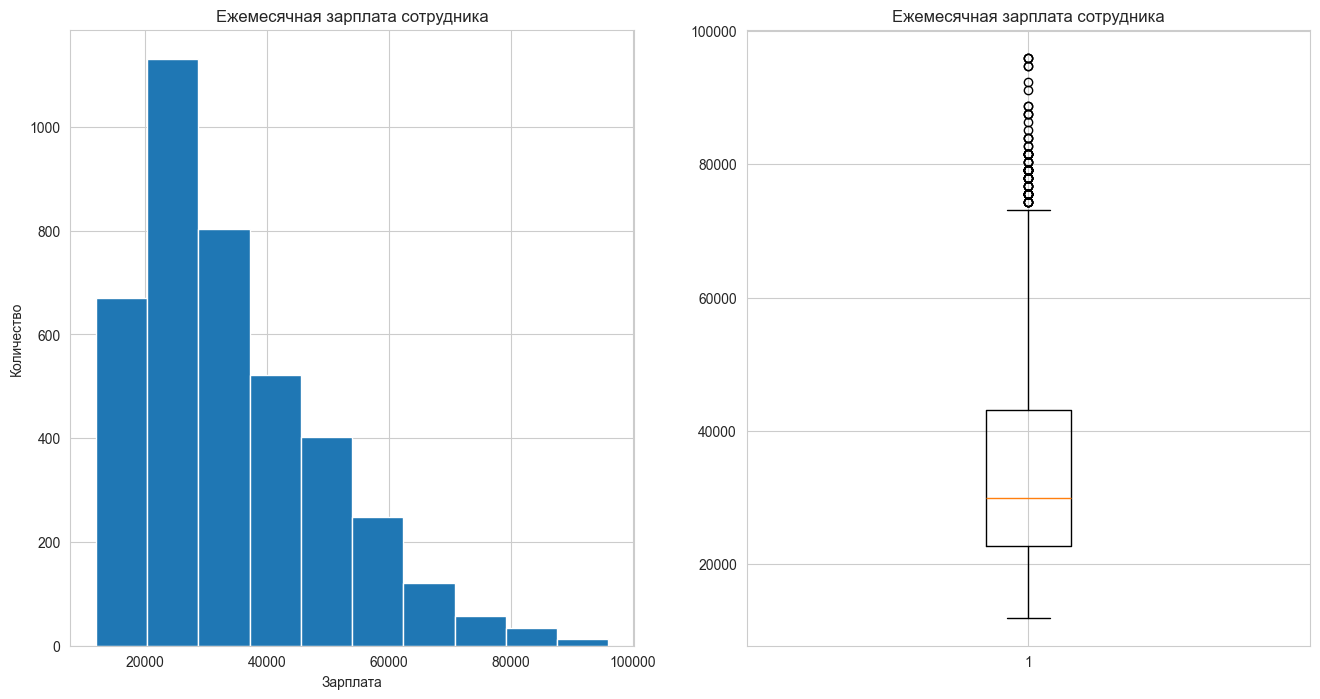

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Зарплата
ax[0].hist(train_quit['salary'], bins=10)
ax[0].set_xlabel('Зарплата')
ax[0].set_ylabel('Количество')
ax[0].set_title('Ежемесячная зарплата сотрудника')

ax[1].boxplot(train_quit['salary'])
ax[1].set_title('Ежемесячная зарплата сотрудника')

plt.show()

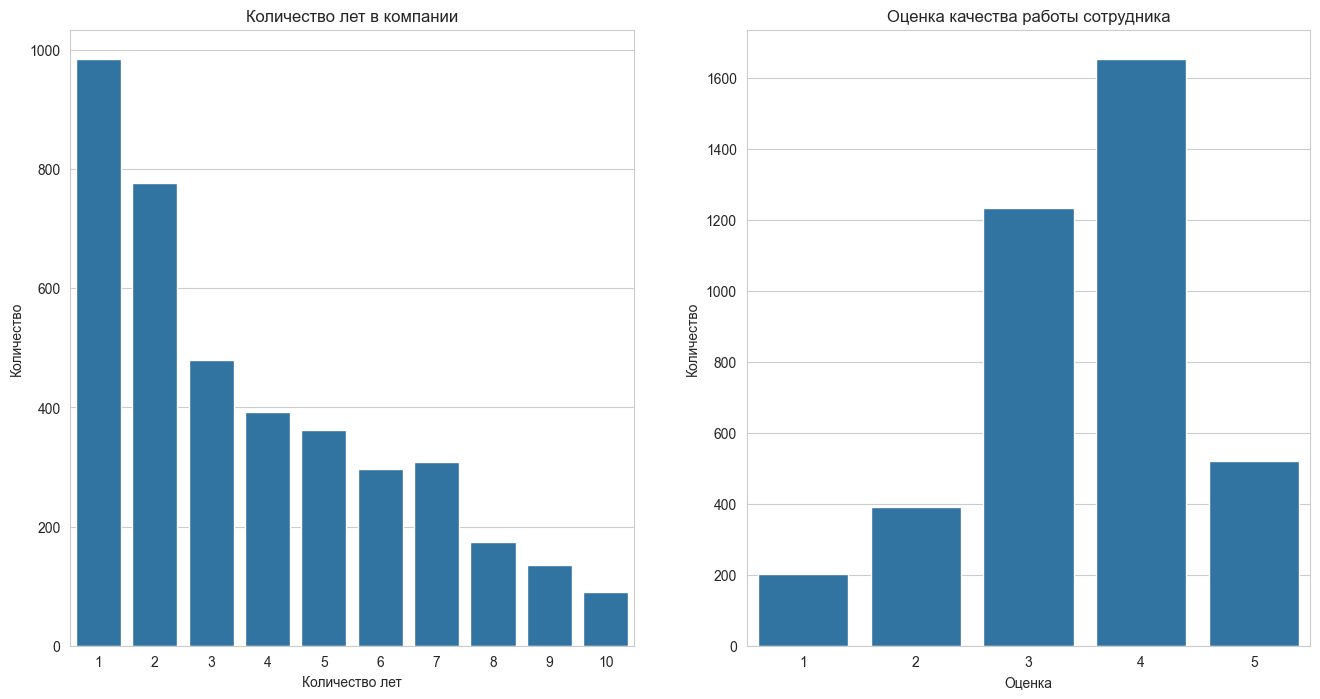

In [49]:
plt.figure(figsize=(16, 8))

# Количество лет в компании
plt.subplot(1, 2, 1)
sns.countplot(train_quit, x='employment_years')
plt.xlabel('Количество лет')
plt.ylabel('Количество')
plt.title('Количество лет в компании')

# Оценка качества работы сотрудника
plt.subplot(1, 2, 2)
sns.countplot(train_quit, x='supervisor_evaluation')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.title('Оценка качества работы сотрудника')

plt.show()

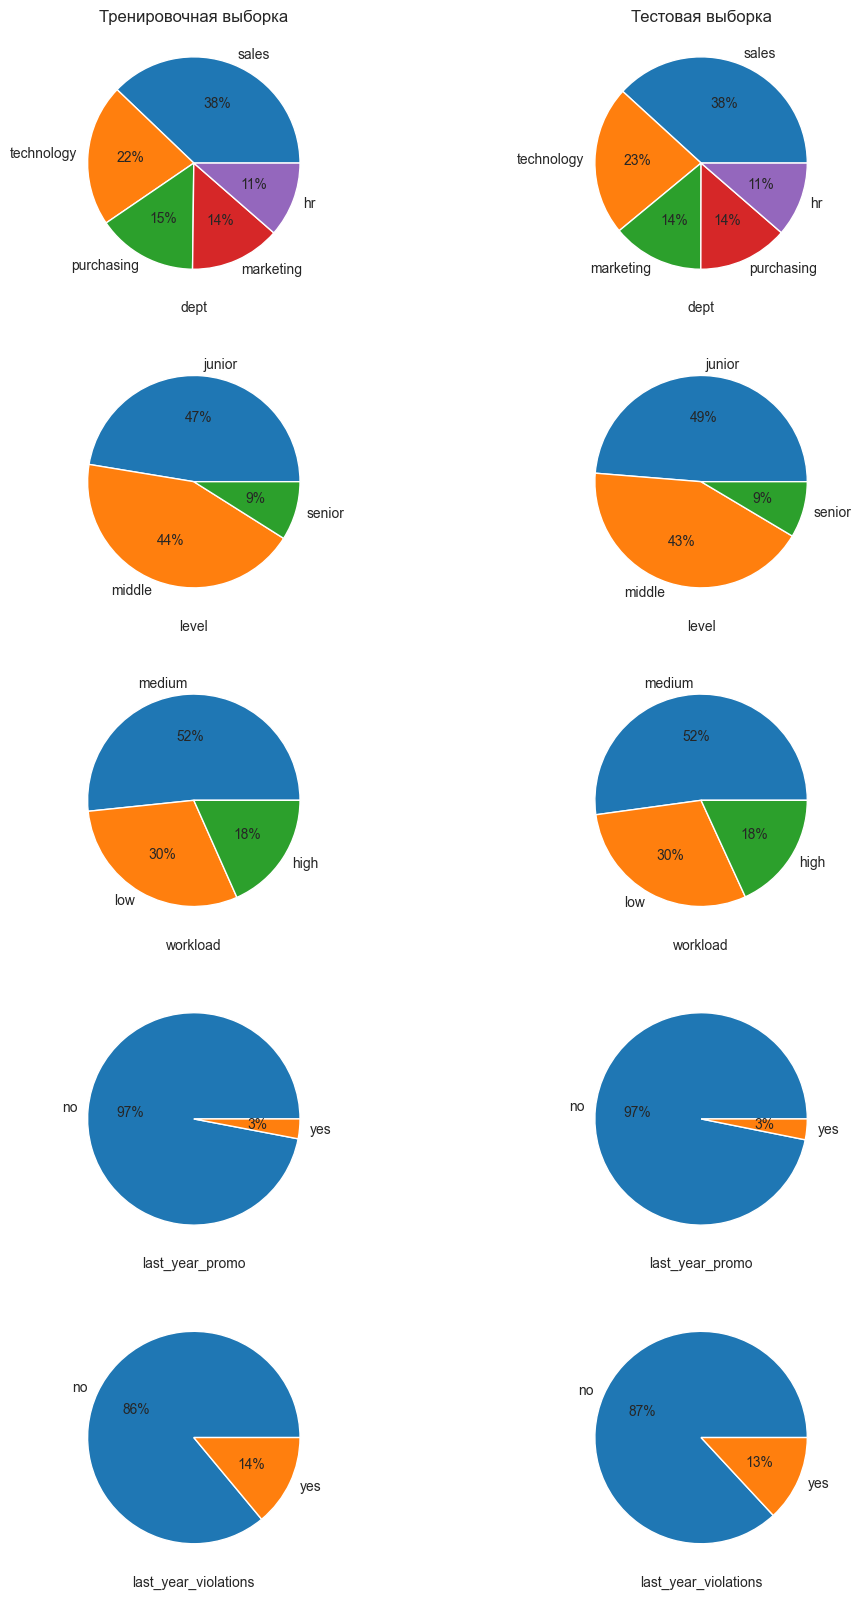

In [50]:
# Посмотрим распределение категориальных значений в тренировочной и тестовой выборках
fig, ax = plt.subplots(5, 2, figsize=(12, 20))

for i in range(len(cat_col_names) - 1):
    ax[i, 0].pie(
        train_satisfaction_rate[cat_col_names[i]].value_counts(),
        labels=train_satisfaction_rate[cat_col_names[i]].value_counts().index,
        autopct='%1.0f%%',
    )
    ax[i, 0].set_xlabel(cat_col_names[i])

    ax[i, 1].pie(
        test_features[cat_col_names[i]].value_counts(),
        labels=test_features[cat_col_names[i]].value_counts().index,
        autopct='%1.0f%%',
    )
    ax[i, 1].set_xlabel(cat_col_names[i])

ax[0, 0].set_title('Тренировочная выборка')
ax[0, 1].set_title('Тестовая выборка')
plt.show()

Так как у нас id в тренировочной выборке первой задачи и второй отличаются, то присвоить `job_satisfaction_rate` по `id` мы не можем. Используем обученную модель, чтобы предсказать уровень удовлетворенности сотрудников и добавим это в тренировочную выборку в столбец `pred_satisfaction_rate`

#### Анализ числовых значений

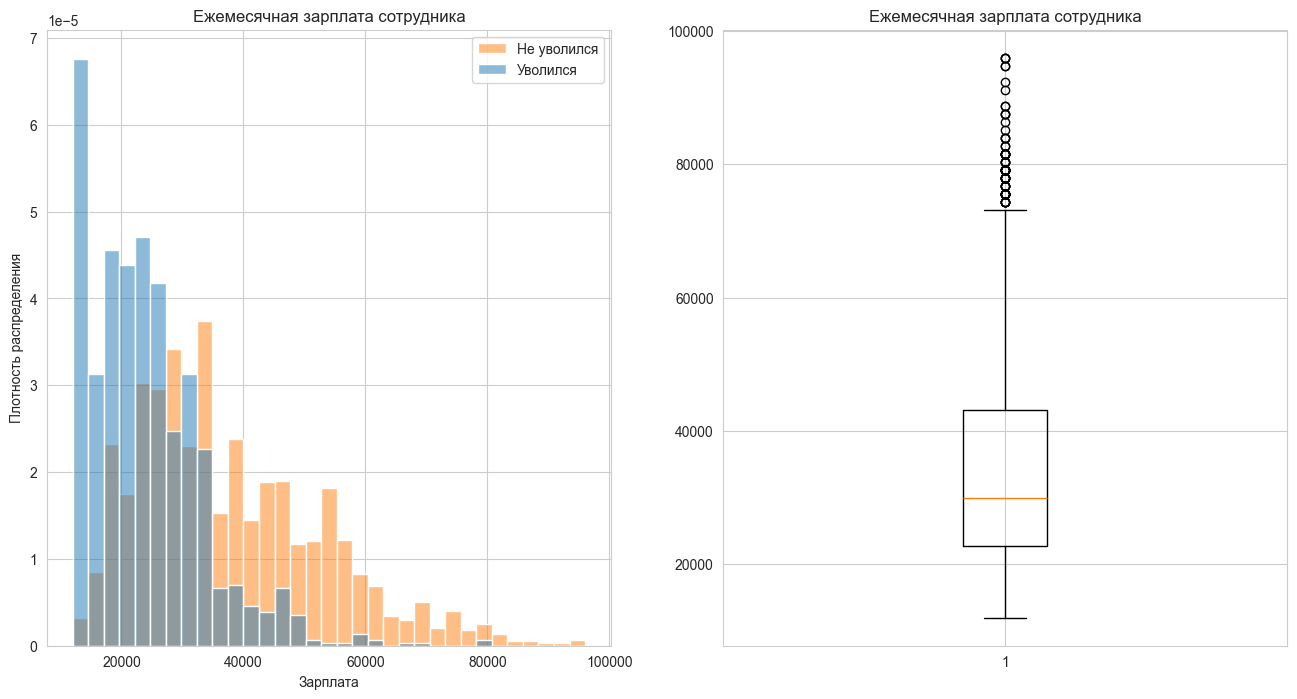

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.histplot(train_quit, x='salary', hue='quit', ax=ax[0], stat='density', common_norm=False)
ax[0].legend(['Не уволился', 'Уволился'])
ax[0].set_xlabel('Зарплата')
ax[0].set_ylabel('Плотность распределения')
ax[0].set_title('Ежемесячная зарплата сотрудника')

ax[1].boxplot(train_quit['salary'])
ax[1].set_title('Ежемесячная зарплата сотрудника')

plt.show()

In [52]:
train_quit.pivot_table(index='quit', values='salary', aggfunc=('mean', 'median'))

,mean,median
quit,,
no,37702.228412,34800.0
yes,23885.106383,22800.0


Зарплата уволившихся сотрудников примерно на треть меньше, чем у тех, кто остался

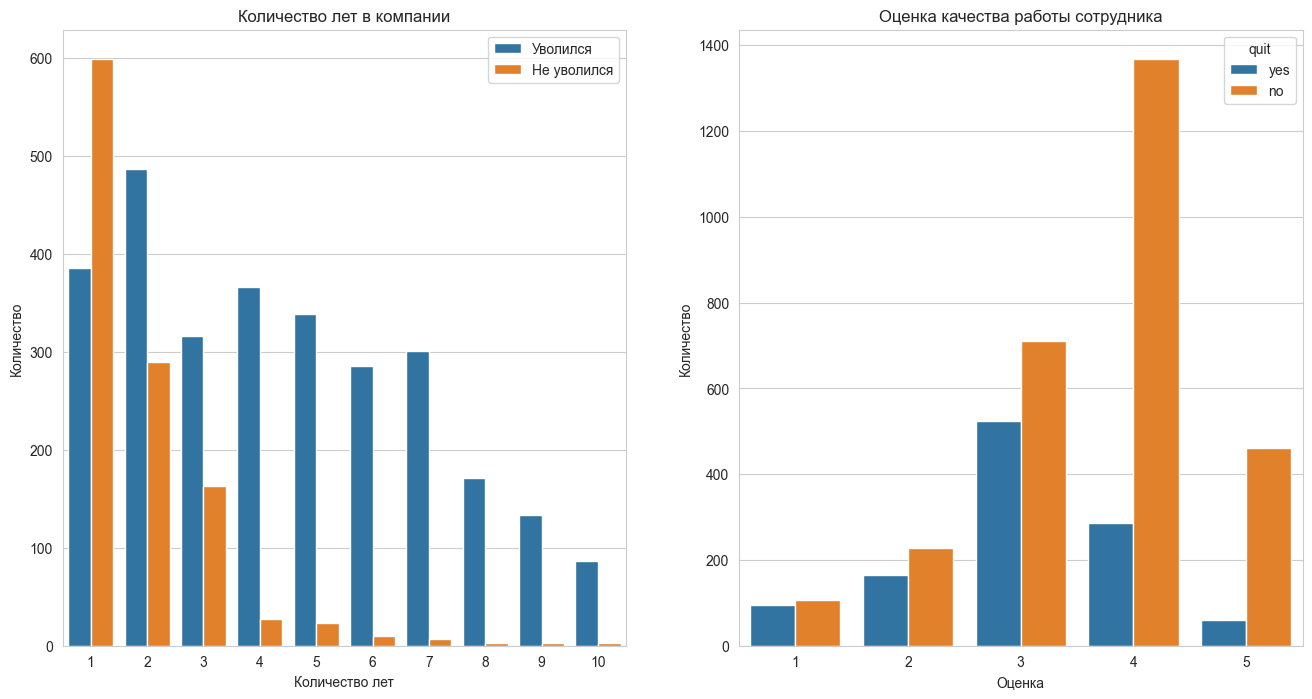

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Количество лет в компании
sns.countplot(train_quit, x='employment_years', ax=ax[0], hue='quit')
ax[0].legend(['Уволился', 'Не уволился'])
ax[0].set_xlabel('Количество лет')
ax[0].set_ylabel('Количество')
ax[0].set_title('Количество лет в компании')

# Оценка качества работы сотрудника
sns.countplot(train_quit, x='supervisor_evaluation', ax=ax[1], hue='quit')
ax[0].legend(['Уволился', 'Не уволился'])
ax[1].set_xlabel('Оценка')
ax[1].set_ylabel('Количество')
ax[1].set_title('Оценка качества работы сотрудника')

plt.show()

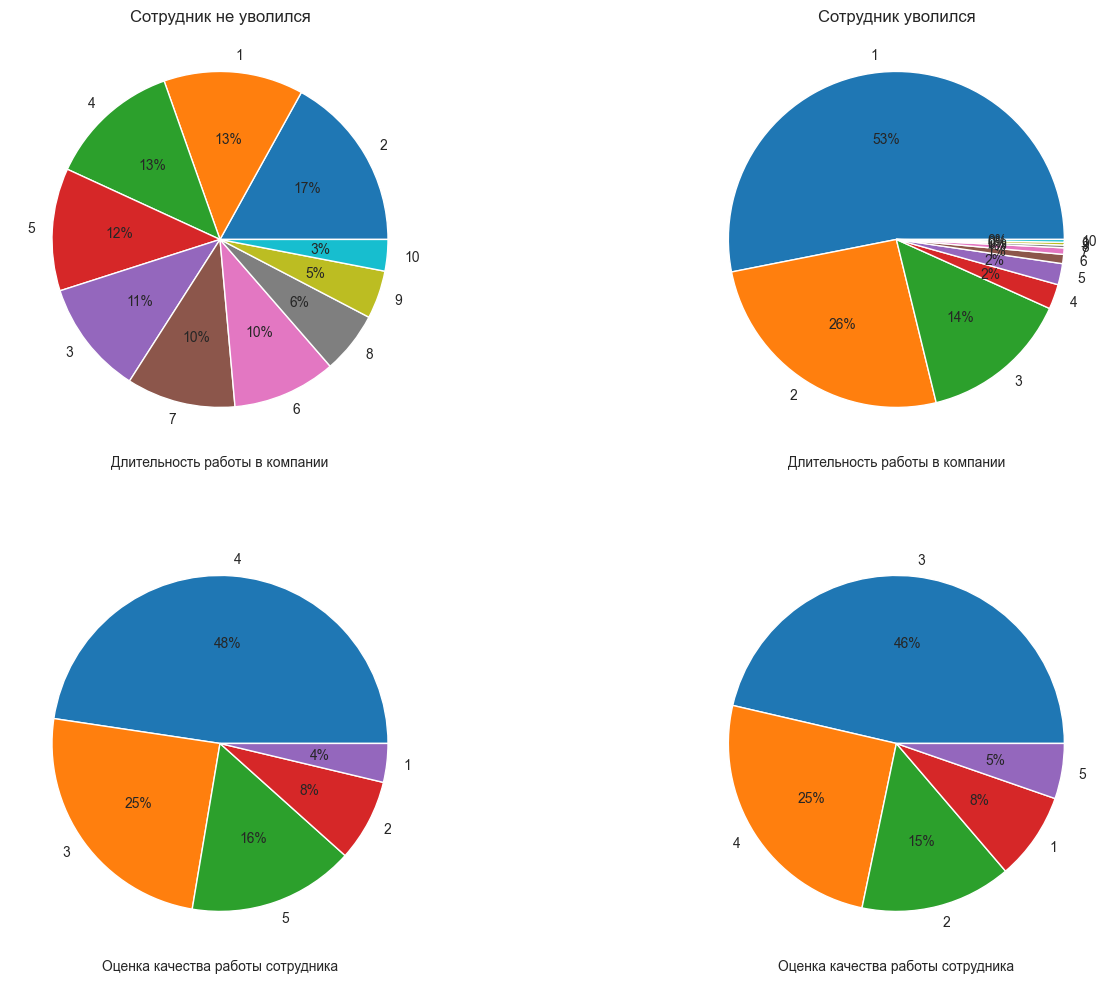

In [54]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

ax[0, 0].pie(
    train_quit.loc[train_quit['quit'] == 'no', 'employment_years'].value_counts(normalize=True),
    labels=train_quit.loc[train_quit['quit'] == 'no', 'employment_years'].value_counts(normalize=True).index,
    autopct='%1.0f%%',
)
ax[0, 0].set_xlabel('Длительность работы в компании')

ax[0, 1].pie(
    train_quit.loc[train_quit['quit'] == 'yes', 'employment_years'].value_counts(normalize=True),
    labels=train_quit.loc[train_quit['quit'] == 'yes', 'employment_years'].value_counts(normalize=True).index,
    autopct='%1.0f%%',
)
ax[0, 1].set_xlabel('Длительность работы в компании')

ax[1, 0].pie(
    train_quit.loc[train_quit['quit'] == 'no', 'supervisor_evaluation'].value_counts(normalize=True),
    labels=train_quit.loc[train_quit['quit'] == 'no', 'supervisor_evaluation'].value_counts(normalize=True).index,
    autopct='%1.0f%%',
)
ax[1, 0].set_xlabel('Оценка качества работы сотрудника')

ax[1, 1].pie(
    train_quit.loc[train_quit['quit'] == 'yes', 'supervisor_evaluation'].value_counts(normalize=True),
    labels=train_quit.loc[train_quit['quit'] == 'yes', 'supervisor_evaluation'].value_counts(normalize=True).index,
    autopct='%1.0f%%',
)
ax[1, 1].set_xlabel('Оценка качества работы сотрудника')

ax[0, 0].set_title('Сотрудник не уволился')
ax[0, 1].set_title('Сотрудник уволился')

plt.show()

- "Длительность работы в годах" — большинство уволившихся сотрудников проработали в компании менее 2 лет. Количество уволившихся снижается по мере увеличения стажа работы. Это может указывать на то, что сотрудники, которые проработали дольше, более лояльны и менее склонны увольняться.
- "Оценка качества работы сотрудника" — большинство уволившихся сотрудников имеют оценку качества работы около 3.5 баллов. Стоит отметить, что сотрудники с более высокими оценками реже увольняются
- "Ежемесячная зарплата сотрудника" — большинство уволившихся сотрудников зарабатывают около 40 000. Однако, здесь также видно, что сотрудники с более высокими зарплатами реже увольняются.
- "Предсказанный уровень удовлетворенности сотрудника" — большинство уволившихся имеют уровень удовлетворенности около 0.7. Сотрудники с более высоким уровнем удовлетворенности реже увольняются

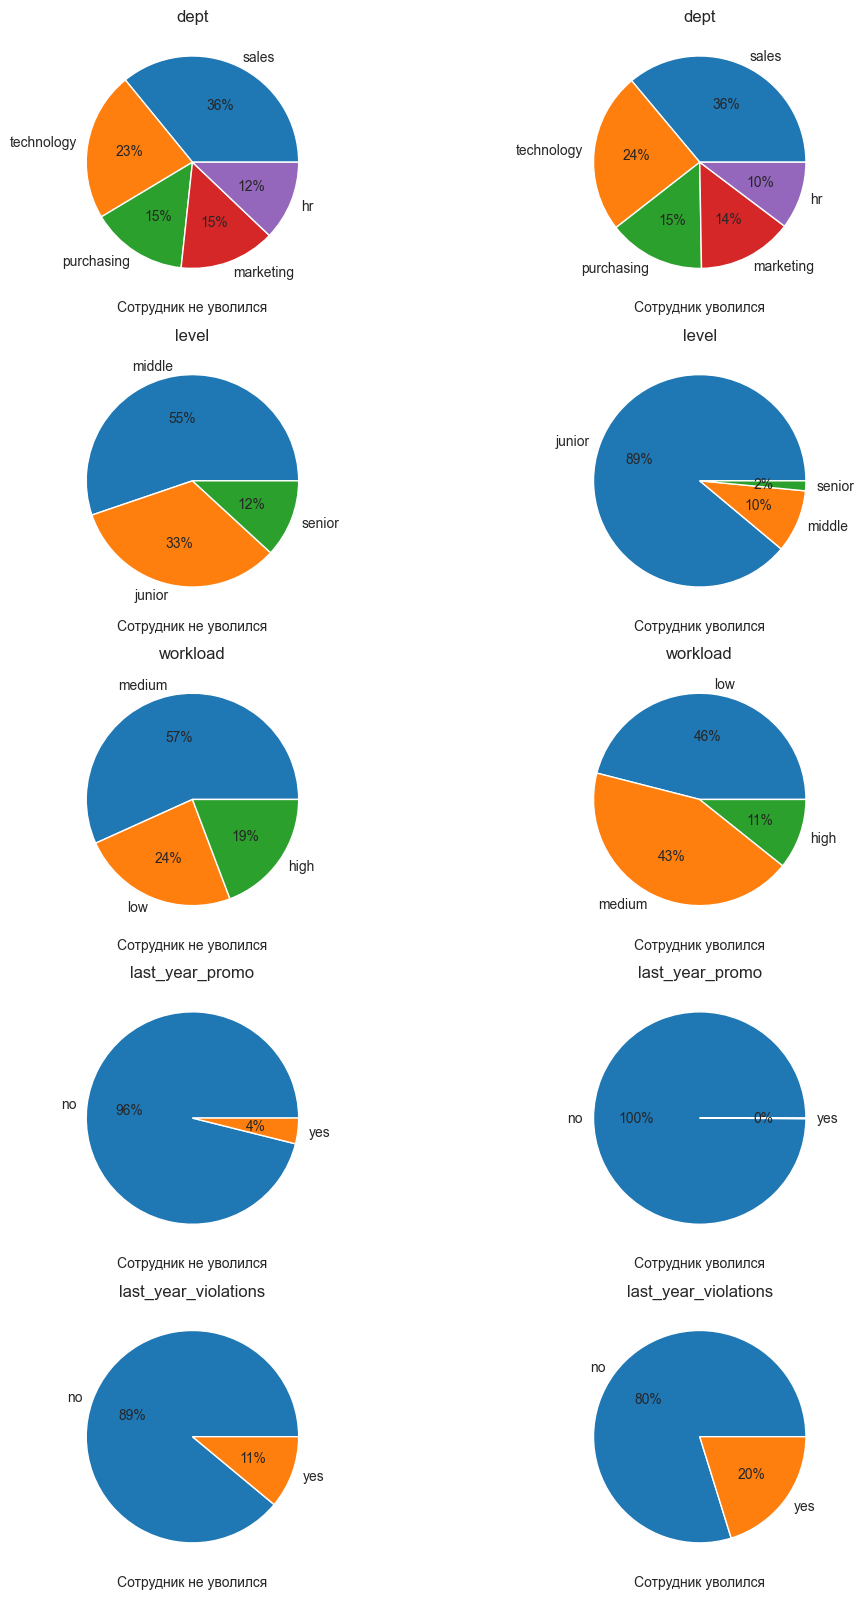

In [55]:
cat_col_names = train_quit.select_dtypes(exclude=['number']).columns.tolist()
fig, ax = plt.subplots(5, 2, figsize=(12, 20))

for i in range(len(cat_col_names) - 1):
    ax[i, 0].pie(
        # train_satisfaction_rate[cat_col_names[i]].value_counts(),
        train_quit.loc[train_quit['quit'] == 'no', cat_col_names[i]].value_counts(),
        labels=train_quit.loc[train_quit['quit'] == 'no', cat_col_names[i]].value_counts().index,
        autopct='%1.0f%%',
    )
    ax[i, 0].set_title(cat_col_names[i])
    ax[i, 0].set_xlabel('Сотрудник не уволился')

    ax[i, 1].pie(
        train_quit.loc[train_quit['quit'] == 'yes', cat_col_names[i]].value_counts(),
        labels=train_quit.loc[train_quit['quit'] == 'yes', cat_col_names[i]].value_counts().index,
        autopct='%1.0f%%',
    )
    ax[i, 1].set_title(cat_col_names[i])
    ax[i, 1].set_xlabel('Сотрудник уволился')

plt.show()

Если смотреть на отдел, из которого чаще увольняются сотрудники, то там лидируют продажи, потом технологический отел. Однако скорее всего это обусловлено просто тем, что в этих отделах большее количество людей, как мы выяснили раньше.<br>
Среди уволившихся преобладают junior-специалисты, в то время как среди оставшихся - middle-специалисты. Это может говорить о том, что junior-специалисты чаще увольняются, возможно, в поисках лучших условий.<br>
Среди уволившихся сотрудников 20% имели нарушения в прошлом году, в то время как среди оставшихся - только 11%. Скорее всего, сотрудники, которые хотят уволиться, более склонны принебрегать правилами трудового договора


Посмотрим, как признаки коррелируют между собой

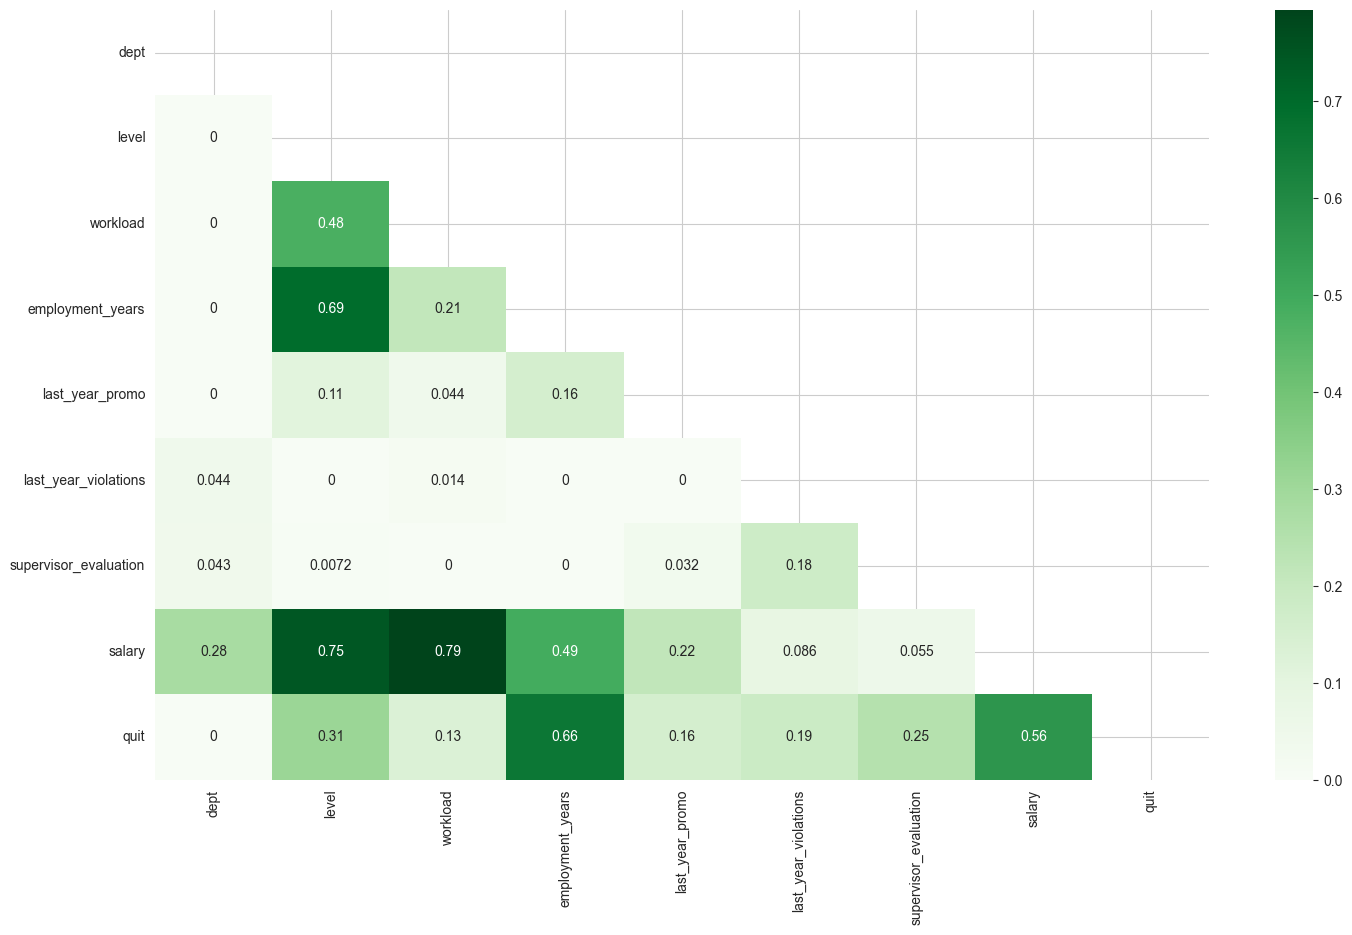

In [56]:
# Создадим хитмап корреляции
plt.figure(figsize=(17, 10))

sns.heatmap(
    train_quit.drop('id', axis=1).phik_matrix(
        interval_cols=['salary', ],
    ),
    annot=True, cmap='Greens',
    mask=(np.triu(np.ones_like(
        train_quit.drop('id', axis=1).phik_matrix(
            interval_cols=['salary', ]),
        dtype=bool)))
)

plt.show()

Мы можем видеть, что last_year_violation и pred_satisfaction_rate имеют очень высокую корреляцию. С одной стороны, это не целевой признак, так что мы можем ничего не делать. С другой же стороны это все равно может добавить модели ошибок. Запомним этот момент и попробуем обучить модель на данных с этим признаком и без него.

Целевой же признак имеет самую высокую корреляцию с количеством проведенных в компании лет и зарплатой. Он не имеет мультиколлинеарности ни с одним из признаков, что безусловно является для нас плюсом.

#### Проверка нового признака

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение: визуализируем и сравним распределения признака `job_satisfaction_rate` для ушедших и оставшихся сотрудников. Используем данные с обоими целевыми признаками тестовой выборки.


In [57]:
# Объединим данные по id
test_features = test_features.merge(test_target_satisfaction_rate, on='id', how='left')
test_features = test_features.merge(test_target_quit, on='id', how='left')
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,100298,hr,junior,low,2,no,no,4,19200,0.80,no
1,100480,marketing,junior,low,4,no,no,4,16800,0.84,no
2,100503,purchasing,middle,high,5,no,no,4,55200,0.79,no
3,100610,sales,middle,medium,5,no,no,4,43200,0.75,no
4,100692,sales,middle,high,6,no,no,4,48000,0.69,no


In [58]:
test_features.pivot_table(index='quit', values='job_satisfaction_rate', aggfunc=('mean', 'median'))

,mean,median
quit,,
no,0.612040,0.66
yes,0.387713,0.37


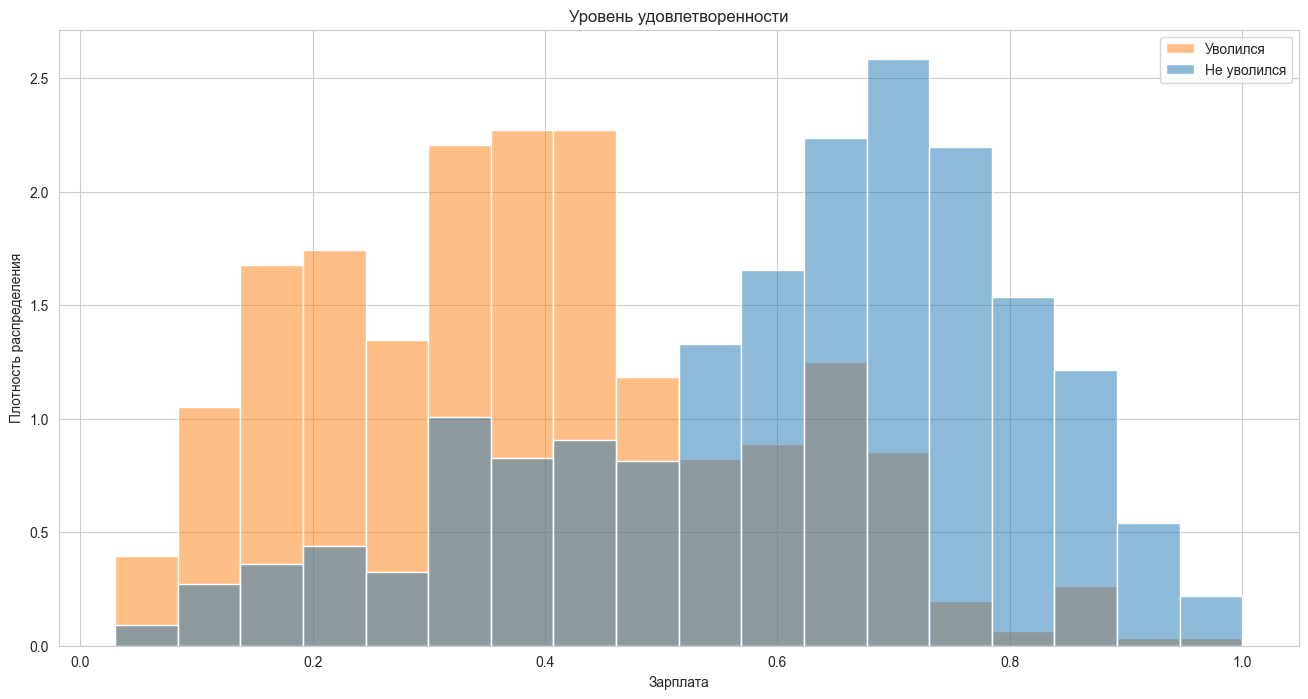

In [59]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.histplot(test_features, x='job_satisfaction_rate', hue='quit', ax=ax, stat='density', common_norm=False)
ax.legend(['Уволился', 'Не уволился'])
ax.set_xlabel('Зарплата')
ax.set_ylabel('Плотность распределения')
ax.set_title('Уровень удовлетворенности')
plt.show()

Мы видим, что удовлетворенность сотрудников в разрезе целевого признака распределены похоже, однако для сотрудников, который не уволились, центр гистограммы сдвинут вправо, что говорит о лучшем. Медианный уровень удовлетворенности для уволившихся сотрудников составляет 0.37, в то время как для оставшихся сотрудников он составляет 0.68

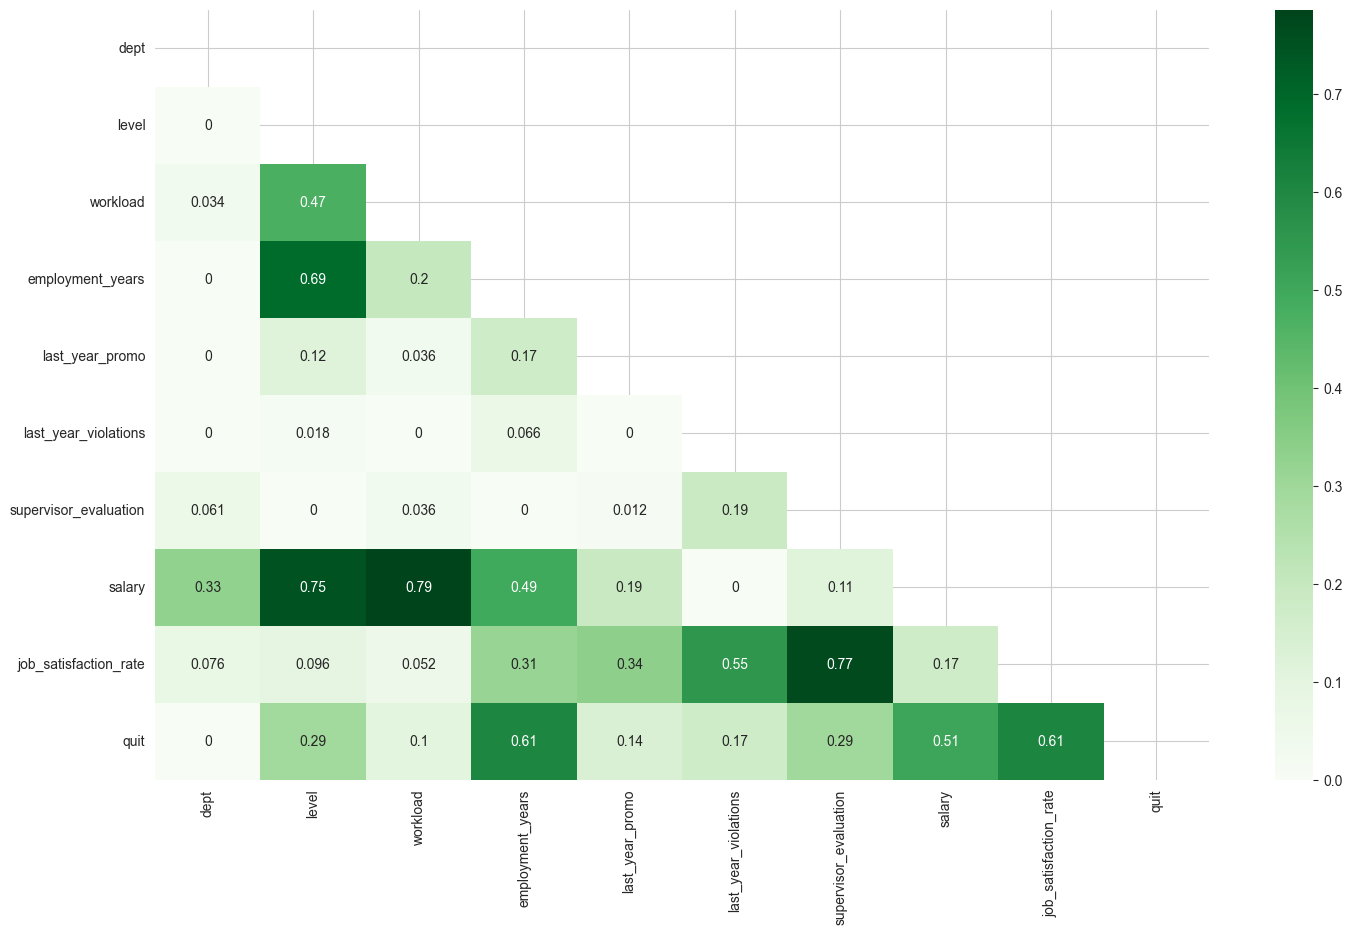

In [60]:
# Создадим хитмап корреляции
plt.figure(figsize=(17, 10))

sns.heatmap(
    test_features.drop('id', axis=1).phik_matrix(
        interval_cols=['salary', 'job_satisfaction_rate'],
    ),
    annot=True, cmap='Greens',
    mask=(np.triu(np.ones_like(
        test_features.drop('id', axis=1).phik_matrix(
            interval_cols=['salary', 'job_satisfaction_rate']),
        dtype=bool)))
)

plt.show()

Признак "уровень удовлетворенности сотрудника" имеет высокую корреляцию с целевым признаком. Добавим его в тренировочную выборку

#### Промежуточный вывод

- "Длительность работы в годах" — большинство уволившихся сотрудников проработали в компании менее 2 лет. Количество уволившихся снижается по мере увеличения стажа работы. Это может указывать на то, что сотрудники, которые проработали дольше, более лояльны и менее склонны увольняться.
- "Оценка качества работы сотрудника" — большинство уволившихся сотрудников имеют оценку качества работы около 3.5 баллов. Стоит отметить, что сотрудники с более высокими оценками реже увольняются
- "Ежемесячная зарплата сотрудника" — большинство уволившихся сотрудников зарабатывают около 40 000. Однако, здесь также видно, что сотрудники с более высокими зарплатами реже увольняются.
- "Предсказанный уровень удовлетворенности сотрудника" — большинство уволившихся имеют уровень удовлетворенности около 0.7. Сотрудники с более высоким уровнем удовлетворенности реже увольняются

Если смотреть на отдел, из которого чаще увольняются сотрудники, то там лидируют продажи, потом технологический отел. Однако скорее всего это обусловлено просто тем, что в этих отделах большее количество людей, как мы выяснили раньше.<br>
Среди уволившихся преобладают junior-специалисты, в то время как среди оставшихся - middle-специалисты. Это может говорить о том, что junior-специалисты чаще увольняются, возможно, в поисках лучших условий.<br>
Среди уволившихся сотрудников 20% имели нарушения в прошлом году, в то время как среди оставшихся - только 11%. Скорее всего, сотрудники, которые хотят уволиться, более склонны принебрегать правилами трудового договора

last_year_violation и pred_satisfaction_rate имеют очень высокую корреляцию. С одной стороны, это не целевой признак, так что мы можем ничего не делать. С другой же стороны это все равно может добавить модели ошибок. Запомним этот момент и попробуем обучить модель на данных с этим признаком и без него.

Целевой же признак имеет самую высокую корреляцию с количеством проведенных в компании лет и зарплатой. Он не имеет мультиколлинеарности ни с одним из признаков, что безусловно является для нас плюсом. Корреляция целевого признака с уровнем удовлетворенности не слишком высока

Удовлетворенность сотрудников в разрезе целевого признака распределены похоже, однако для сотрудников, который не уволились, центр гистограммы сдвинут вправо, что говорит о лучшем. Медианный уровень удовлетворенности для уволившихся сотрудников составляет 0.37, в то время как для оставшихся сотрудников он составляет 0.68. Признак "уровень удовлетворенности сотрудника" имеет высокую корреляцию с целевым признаком. Добавим его в тренировочную выборку


На основе диаграмм, мы составили портрет уволившегося сотрудника:
 - Длительность работы — Сотрудники, проработавшие менее 2 лет, более склонны увольняться.
 - Оценка качества работы — сотрудники с оценкой качества работы около 3.5 баллов чаще увольняются.
 - Зарплата — сотрудники с зарплатой около 40 000 чаще увольняются.
 - Уровень удовлетворенности — сотрудники с уровнем удовлетворенности около 0.7 чаще увольняются.
 - Отдел — сотрудники из отделов продаж и технологий чаще увольняются.
 - Уровень — junior-специалисты чаще увольняются.
 - Нагрузка — сотрудники со средней и низкой нагрузкой чаще увольняются.
 - Нарушения в прошлом году — сотрудники с нарушениями в прошлом году чаще увольняются.


### Добавление нового входного признака

Ранее мы выявили, что признаки `job_satisfaction_rate` и `quit` имеют высокую корреляцию. Так как мы получили необходимое значение метрики в первой задачи, то добавим `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи в тренировочную выборку второй задачи `train_quit`

In [61]:
# Предсказываем значение с помощью лучшей модели, найденной в задаче 1
train_quit['pred_satisfaction_rate'] = random_search.best_estimator_.predict(train_quit.drop(columns=['id'], axis=1))
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,pred_satisfaction_rate
2600,100222,sales,junior,medium,3,no,no,2,20400,yes,0.6700
717,100459,purchasing,junior,medium,3,no,no,3,21600,yes,0.6700
2455,100469,marketing,junior,medium,1,no,no,4,28800,no,0.7925
1592,100601,technology,middle,high,4,no,no,4,68400,no,0.8000
2657,100858,sales,junior,medium,2,no,no,4,25200,yes,0.8720


In [62]:
# Предсказываем значение с помощью лучшей модели, найденной в задаче 1
test_features['pred_satisfaction_rate'] = random_search.best_estimator_.predict(test_features.drop(columns=['id', 'job_satisfaction_rate'], axis=1))
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit,pred_satisfaction_rate
0,100298,hr,junior,low,2,no,no,4,19200,0.80,no,0.827143
1,100480,marketing,junior,low,4,no,no,4,16800,0.84,no,0.792500
2,100503,purchasing,middle,high,5,no,no,4,55200,0.79,no,0.840000
3,100610,sales,middle,medium,5,no,no,4,43200,0.75,no,0.872000
4,100692,sales,middle,high,6,no,no,4,48000,0.69,no,0.850000


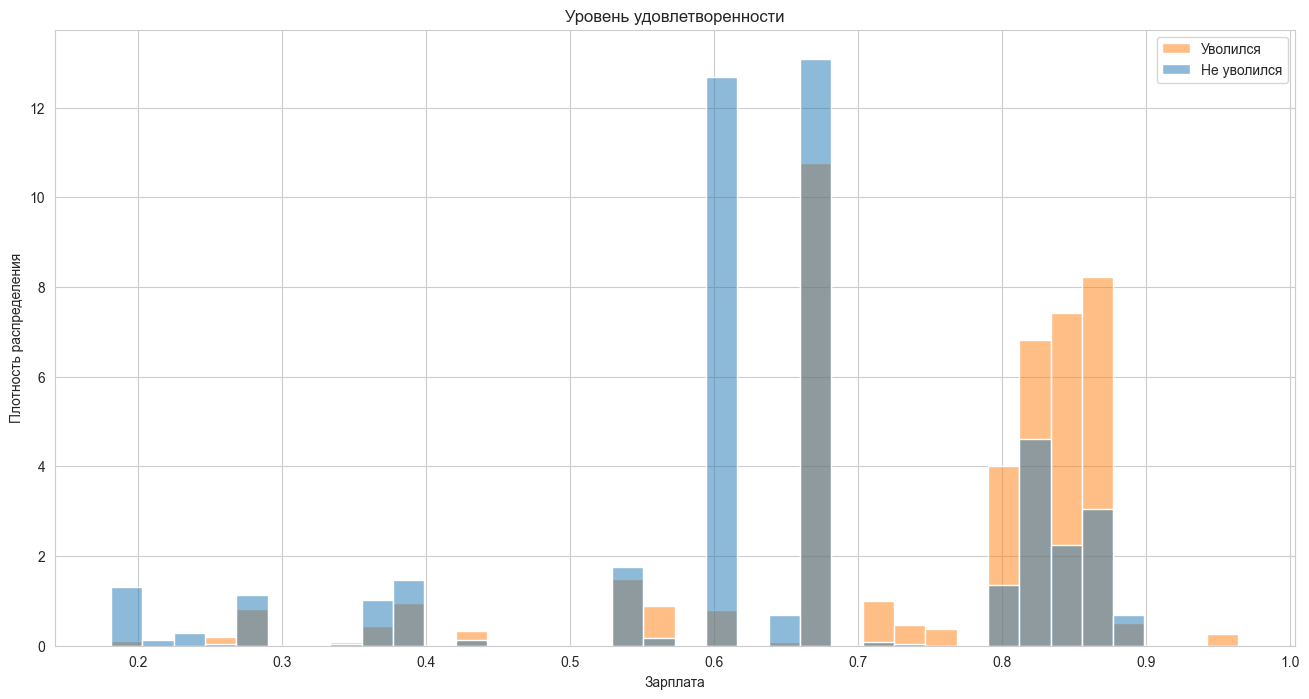

In [63]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.histplot(train_quit, x='pred_satisfaction_rate', hue='quit', ax=ax, stat='density', common_norm=False)
ax.legend(['Уволился', 'Не уволился'])
ax.set_xlabel('Зарплата')
ax.set_ylabel('Плотность распределения')
ax.set_title('Уровень удовлетворенности')
plt.show()

Распределение у нас даже близко не похоже на распределение тестовой выборки. Возможно, нам придется убрать этот признак из тренировочной выборки

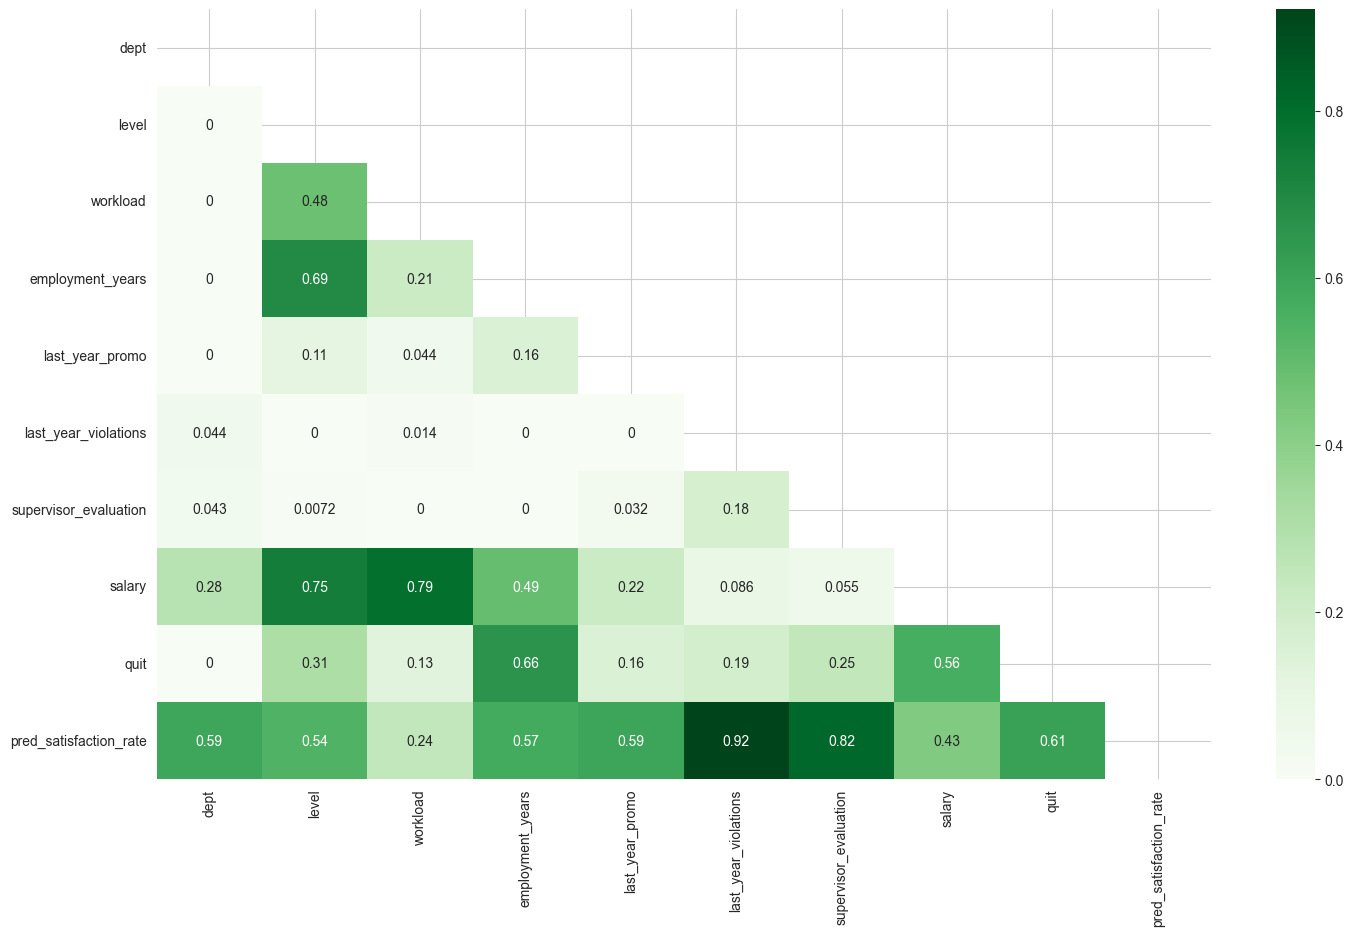

In [64]:
# Создадим хитмап корреляции
plt.figure(figsize=(17, 10))

sns.heatmap(
    train_quit.drop('id', axis=1).phik_matrix(
        interval_cols=['salary', 'job_satisfaction_rate', 'pred_satisfaction_rate'],
    ),
    annot=True, cmap='Greens',
    mask=(np.triu(np.ones_like(
        train_quit.drop('id', axis=1).phik_matrix(
            interval_cols=['salary', 'job_satisfaction_rate', 'pred_satisfaction_rate'],),
        dtype=bool)))
)

plt.show()

Новый признак мультиколлинеарен почти со всеми признаками, а с признаком `last_year_violations` корреляция составляет вообще 1. Однако с целевым признаком коллинеарность не очень велика, потому этот признак не сильно повлияет на предсказания модели. Будем иметь это ввиду.

#### Промежуточный вывод
Мы добавили новый входной признак в тренировочную и тестовую выборки. Он мультиколлинеарен почти со всеми признаками, однако с целевым корреляцияя не очень высока.

### Подготовка данных

Подготовим признаки так же, как и в первой задаче: выполним подготовку в пайплайне, дополнив пайплайн предобработки.

In [65]:
# Указываем новые столбцы
num_columns = ['employment_years', 'salary', 'pred_satisfaction_rate', 'supervisor_evaluation']
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']

In [66]:
# Обновляем препроцессор после обновления колонок
data_preprocessor = ColumnTransformer(
    [
        ('num', num_pipeline, num_columns),
        ('ohe', ohe_pipeline, ohe_columns),
        ('ord', ord_pipeline, ord_columns),
    ],
    remainder='passthrough',
)

final_calssif_pipeline = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('select_k_best', SelectKBest(score_func=f_classif, k=10)),
        ('models', DummyClassifier()),
    ]
)

In [67]:
label_encoder = LabelEncoder()

X_quit = train_quit.drop(columns=['quit', 'id', ], axis=1)
y_quit = label_encoder.fit_transform(train_quit['quit'])
label_encoder.classes_ = np.array(['no', 'yes'])

X_test = test_features.drop(columns=['id', 'quit', 'job_satisfaction_rate'], axis=1)
y_test = label_encoder.transform(test_target_quit['quit'])

In [68]:
# Создаем сетку параметров
param_grid_calssif = [
    # Словарь для логистической регрессии
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 50),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough'],
        'select_k_best__k': range(5, X_quit.shape[1] + 1),
    },

    # Словарь для метода опорных векторов(SVC)
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True, class_weight='balanced')],
        'models__C': range(1, 50),
        'models__kernel': ['rbf', 'poly', 'sigmoid'],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough'],
        'select_k_best__k': range(5, X_quit.shape[1] + 1),
    },

    # Словарь для метода ближайших соседей
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 50),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough'],
        'select_k_best__k': range(5, X_quit.shape[1] + 1),
    },

    # Словарь для дерева решений
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__max_depth': range(1, 50),
        'models__max_features': range(1, 50),
        'models__min_samples_leaf': range(1, 50),
        'models__min_samples_split': range(2, 50),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough'],
        'select_k_best__k': range(5, X_quit.shape[1] + 1),
    }
]

#### Промежуточный вывод

Мы создали сетку параметров для обучения модели классификации

### Обучение модели

In [69]:
random_search_classif = RandomizedSearchCV(
    final_calssif_pipeline,
    param_grid_calssif,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
)

In [70]:
random_search_classif.fit(X_quit, y_quit)
print(random_search_classif.best_score_)
random_search_classif.best_estimator_

0.936739083899716


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['employment_years', 'salary',
                                                   'pred_satisfaction_rate',
                                                   'supervisor_evaluation']),
                                                 ('ohe',
                                                  Pipeline(steps=[('imputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=Fa...
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('imputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload'])])),
                ('select_k_best', SelectKBest(k=7)),
                ('models',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=40,
                                        max_features=26, min_samples_leaf=17,
                                        min_samples_split=31,
                                        random_state=42))])

In [71]:
y_quit_pred_proba = random_search_classif.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_quit_pred_proba)
roc_auc

np.float64(0.9225716875086429)

Качество модели на тестовой выборке составляет `0.92`, что выше необходимого нам порога в `0.91`. Модель хорошо себя показывает после добавления нового входного признака `job_satisfaction_rate`

#### Промежуточный вывод

Мы создали сетку гиперпараметров, обучили модель, и проверили ее, используя кросс-валидацию. Для подбора гиперпараметров мы использовали `RandomizedSearchCV`

Мы использовали метод отбора самых значимых признаков `SelectKBest`. Данным методом мы отобрали 7 признаков
Лучше всего себя показала модель `DecisionTreeClassifier` со следующими гиперпараметрами:
 - class_weight='balanced'
 - max_depth=29
 - max_features=25
 - min_samples_leaf=11
 - min_samples_split=28

Качество модели на тестовой выборке составляет `0.92`, что выше необходимого нам порога в `0.91`. Модель хорошо себя показывает после добавления нового входного признака `job_satisfaction_rate`

### Анализ важности признаков

In [72]:
X_train_shap = pd.DataFrame(
    final_linear_pipeline.named_steps['preprocessor'].fit_transform(X_quit),
    columns=final_linear_pipeline.named_steps['preprocessor'].get_feature_names_out()
)

X_test_shap = pd.DataFrame(
    final_linear_pipeline.named_steps['preprocessor'].transform(X_test),
    columns=final_linear_pipeline.named_steps['preprocessor'].get_feature_names_out()
)

model = random_search_classif.best_estimator_.named_steps['models']
model.fit(X_train_shap, y_quit)

explainer = shap.TreeExplainer(model, X_train_shap)

shap_values = explainer(X_test_shap, check_additivity=False)

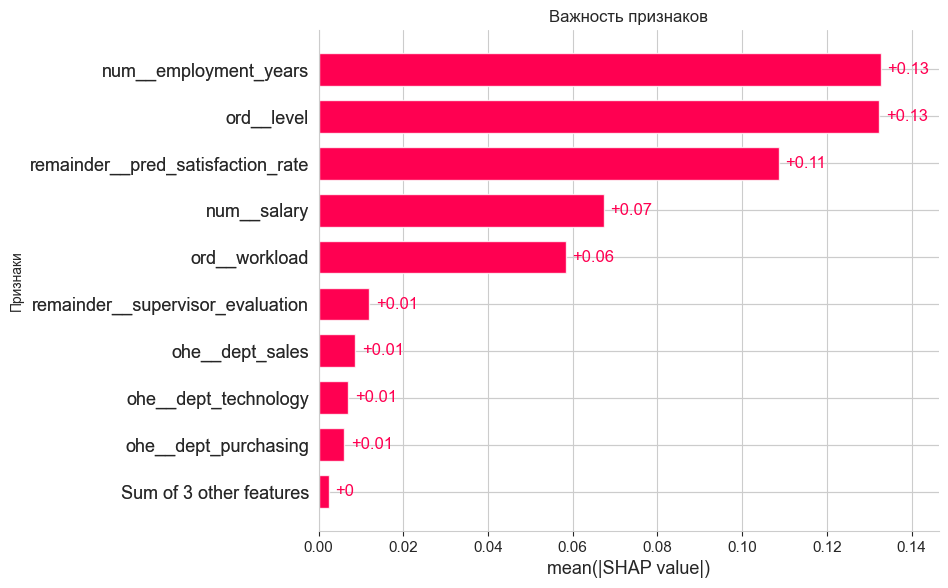

In [73]:
shap.plots.bar(shap_values[:, :, 1], max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()

ax.set_ylabel('Признаки')
ax.set_title('Важность признаков')
plt.show()

Наиболее важные признаки, на основании которых модель принимает решение — это:
- Количество лет, проведенных в компании
- Уровень занимаемой должности
- Оценка качества работы сотрудника, которую дал руководитель
- Зарплата
- Рабочая нагрузка

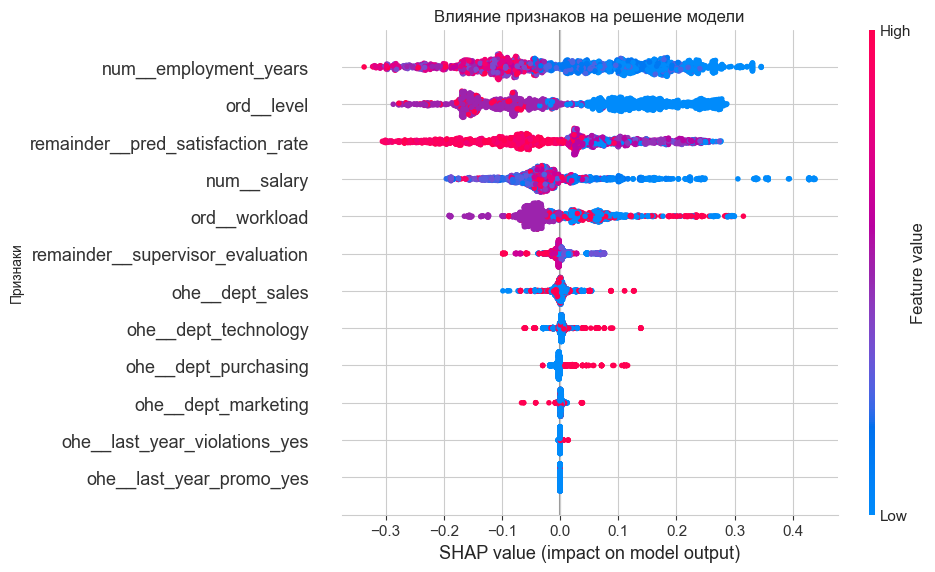

In [74]:
shap.plots.beeswarm(shap_values[:, :, 1], max_display=15, show=False)
fig, ax = plt.gcf(), plt.gca()

ax.set_ylabel('Признаки')
ax.set_title('Влияние признаков на решение модели')
plt.show()

- Чем больше количество лет, проведенных в компании, тем меньше вероятность, что сотрудник уволится
- Чем выше уровень занимаемой должности, тем меньше вероятность, что сотрудник уволится
- Чем выше оценка качества работы сотрудника, которую дал руководитель, тем меньше вероятность, что сотрудник уволится
- В случае с зарплатой нельзя выделить какую-то закономерность. Сотрудники увольнялись имея и высокую и низкую зарплату.
- Чем выше рабочая нагрузка, тем меньше вероятность, что сотрудник уволится, однако есть несколько исключений. Для некоторых сотрудников, большая нагрузка является одной из причин увольнения. Сотрудники со средней нагрузкой ведут себя предсказуемее всего: они не склонны увольняться

#### Промежуточный вывод:

Мы выделили 5 наиболее важных признаков, которые влияют на решения модели, проанализировав то, как значения каждого из признаков влияет на решение модели
- Чем больше количество лет, проведенных в компании, тем меньше вероятность, что сотрудник уволится
- Чем выше уровень занимаемой должности, тем меньше вероятность, что сотрудник уволится
- Чем выше оценка качества работы сотрудника, которую дал руководитель, тем меньше вероятность, что сотрудник уволится
- В случае с зарплатой нельзя выделить какую-то закономерность. Сотрудники увольнялись имея и высокую и низкую зарплату.
- Чем выше рабочая нагрузка, тем меньше вероятность, что сотрудник уволится, однако есть несколько исключений. Для некоторых сотрудников, большая нагрузка является одной из причин увольнения. Сотрудники со средней нагрузкой ведут себя предсказуемее всего: они не склонны увольняться

### Вывод

Во время исследовательского анализа мы выяснили следующее:
- "Длительность работы в годах" — большинство уволившихся сотрудников проработали в компании менее 2 лет. Количество уволившихся снижается по мере увеличения стажа работы. Это может указывать на то, что сотрудники, которые проработали дольше, более лояльны и менее склонны увольняться.
- "Оценка качества работы сотрудника" — большинство уволившихся сотрудников имеют оценку качества работы около 3.5 баллов. Стоит отметить, что сотрудники с более высокими оценками реже увольняются
- "Ежемесячная зарплата сотрудника" — большинство уволившихся сотрудников зарабатывают около 40 000. Однако, здесь также видно, что сотрудники с более высокими зарплатами реже увольняются.
- "Предсказанный уровень удовлетворенности сотрудника" — большинство уволившихся имеют уровень удовлетворенности около 0.7. Сотрудники с более высоким уровнем удовлетворенности реже увольняются

Если смотреть на отдел, из которого чаще увольняются сотрудники, то там лидируют продажи, потом технологический отел. Однако скорее всего это обусловлено просто тем, что в этих отделах большее количество людей, как мы выяснили раньше.<br>
Среди уволившихся преобладают junior-специалисты, в то время как среди оставшихся - middle-специалисты. Это может говорить о том, что junior-специалисты чаще увольняются, возможно, в поисках лучших условий.<br>
Среди уволившихся сотрудников 20% имели нарушения в прошлом году, в то время как среди оставшихся - только 11%. Скорее всего, сотрудники, которые хотят уволиться, более склонны принебрегать правилами трудового договора

last_year_violation и pred_satisfaction_rate имеют очень высокую корреляцию. С одной стороны, это не целевой признак, так что мы можем ничего не делать. С другой же стороны это все равно может добавить модели ошибок. Запомним этот момент и попробуем обучить модель на данных с этим признаком и без него.

Целевой же признак имеет самую высокую корреляцию с количеством проведенных в компании лет и зарплатой. Он не имеет мультиколлинеарности ни с одним из признаков, что безусловно является для нас плюсом. Корреляция целевого признака с уровнем удовлетворенности не слишком высока

Мы добавили новый входной признак в тренировочную и тестовую выборки: `pred_satisfaction_rate` — предсказанный уровень удовлетворенности сотрудника

Во время обучения модели, мы создали сетку гиперпараметров, обучили модель, и проверили ее, используя кросс-валидацию. Для подбора гиперпараметров мы использовали `RandomizedSearchCV`

Мы использовали метод отбора самых значимых признаков `SelectKBest`. Данным методом мы отобрали 7 признаков
Лучше всего себя показала модель `DecisionTreeClassifier` со следующими гиперпараметрами:
 - class_weight='balanced'
 - max_depth=29
 - max_features=25
 - min_samples_leaf=11
 - min_samples_split=28

Качество модели на тестовой выборке составляет `0.92`, что выше необходимого нам порога в `0.91`. Модель хорошо себя показывает после добавления нового входного признака `job_satisfaction_rate`

Мы выделили 5 наиболее важных признаков, которые влияют на решения модели, проанализировав то, как значения каждого из признаков влияет на решение модели
- Чем больше количество лет, проведенных в компании, тем меньше вероятность, что сотрудник уволится
- Чем выше уровень занимаемой должности, тем меньше вероятность, что сотрудник уволится
- Чем выше оценка качества работы сотрудника, которую дал руководитель, тем меньше вероятность, что сотрудник уволится
- В случае с зарплатой нельзя выделить какую-то закономерность. Сотрудники увольнялись имея и высокую и низкую зарплату.
- Чем выше рабочая нагрузка, тем меньше вероятность, что сотрудник уволится, однако есть несколько исключений. Для некоторых сотрудников, большая нагрузка является одной из причин увольнения. Сотрудники со средней нагрузкой ведут себя предсказуемее всего: они не склонны увольняться


На основе диаграмм, мы составили портрет уволившегося сотрудника:
 - Длительность работы — Сотрудники, проработавшие менее 2 лет, более склонны увольняться.
 - Оценка качества работы — сотрудники с оценкой качества работы около 3.5 баллов чаще увольняются.
 - Зарплата — сотрудники с зарплатой около 40 000 чаще увольняются.
 - Уровень удовлетворенности — сотрудники с уровнем удовлетворенности около 0.7 чаще увольняются.
 - Отдел — сотрудники из отделов продаж и технологий чаще увольняются.

## Общий вывод

Во время решения задачи **регрессии**, при котором мы предсказывали уровень удовлетворенности сотрудником, мы подметили следующие наблюдения:

<br>
<br>

Во время исследовательского анализа, мы обнаружили, что в компании довольно много людей, которые работают там недавно. Распределение удовлетворенности почти равномерное, с небольшим смещением к 0.6.<br>
Мы заметили дисбаланс классов, однако мы решили не использовать никакую из технологий сэмплинга, чтобы устранить дисбаланс. Такое решение было принято потому что в противном случае мы бы исказили данные, нарушив "положение дел" в компании. Мы использовали стратификацию.<br>
Медианный уровень удовлетворенности примерно одинаковый для каждого уровня сотрудников.<br>

<br>
<br>

Зарплата — признак, который больше всех коррелирует со всеми остальными. Мы видим, что зарплата очень сильно коррелирует с нагрузкой и уровнем сотрудника. Так же есть корреляция с длительностью работы в компании. Так же мы видим высокую коллинеарность между уровнем удовлетворения сотрудника компанией и уровнем удовлетворения компании сотрудником. Логично предположить, что чем меньше сотруднику нравится компания, тем хуже он выполняет работу и тем меньше компания оценивает этого сотрудника. Этот признак мультиколлинеарен<br>
Всего у нас 201 сотрудник, которыми работодатель недоволен. Эти сотрудники же в свою очередь тоже не очень довольны, потому что их медианный уровень удовлетворенности составляет всего `0.31`.

<br>
<br>

Во время предобработки данных, мы решили, что все выбивающиеся значения (как, например, пробелы) и пропуски будут заменяться на самое часто встречаемое значение.<br>
Для поиска наилучших гиперпараметров мы использовали `RandomizedSearchCV`.<br>
Мы так же создали свою собственную метрику `symmetric mean absolute percentage error`, которая показывает, насколько процентов в среднем отклоняются предсказания.<br>
Лучше всего сработала модель `DecisionTreeRegressor` со следующими параметрами:
 - max_depth=24
 - max_features=39
 - min_samples_leaf=3
 - min_samples_split=9<br>
На тренировочной выборке мы получили значение метрики, равной 15.4%. На валидацонной и тестовых выборках мы получили значение в `14.6%` и `14.5%` соответственно.

<br>
<br>

Мы выделили 6 значений, которые больше всего влияют на уровень удовлетворенности сотрудника:
 - `supervisor_evaluation` - чем меньше метрика, тем меньше целевой признак.
 - `employment_years` - чем больше время, проведенное в компании, тем больше его уровень удовлетворенности.
 - `level` - чем меньше уровень сотрудника, тем выше его удовлетворенность.
 - `salary` - чем выше зарплата, тем выше уровень удовлетворенности сотрудника.
 - `last_year_violations` - наличие нарушений с большей вероятностью понизит удовлетворенность сотрудника.
 - `workload` - чем меньше уровень загруженности сотрудника, тем больше его удовлетворенность. <br>
Стоит отметить, что признак `supervisor_evaluation` влияет больше всего, однако это признак, который не влияет напрямую на уровень удовлетворенности сотрудника. Скорее всего, это внутренняя информация компании, недоступная сотруднику. Тем не менее, если обучать модель без него, то качество модели ухудшается почти в 2 раза, и метрика составит почти 30%.


<br>
<br>
<br>
<br>


Во время решения задачи **бинарной классификации**, при котором мы предсказывали уволится ли сотрудник, мы подметили следующие наблюдения:

<br>
<br>

Во время исследовательского анализа мы выяснили следующее:
 - "Длительность работы в годах" — большинство уволившихся сотрудников проработали в компании менее 2 лет. Количество уволившихся снижается по мере увеличения стажа работы. Это может указывать на то, что сотрудники, которые проработали дольше, более лояльны и менее склонны увольняться.
 - "Оценка качества работы сотрудника" — большинство уволившихся сотрудников имеют оценку качества работы около 3.5 баллов. Стоит отметить, что сотрудники с более высокими оценками реже увольняются
 - "Ежемесячная зарплата сотрудника" — большинство уволившихся сотрудников зарабатывают около 40 000. Однако, здесь также видно, что сотрудники с более высокими зарплатами реже увольняются.
 - "Предсказанный уровень удовлетворенности сотрудника" — большинство уволившихся имеют уровень удовлетворенности около 0.7. Сотрудники с более высоким уровнем удовлетворенности реже увольняются

Если смотреть на отдел, из которого чаще увольняются сотрудники, то там лидируют продажи, потом технологический отел. Однако скорее всего это обусловлено просто тем, что в этих отделах большее количество людей, как мы выяснили раньше.<br>
Среди уволившихся преобладают junior-специалисты, в то время как среди оставшихся - middle-специалисты. Это может говорить о том, что junior-специалисты чаще увольняются, возможно, в поисках лучших условий.<br>
Среди уволившихся сотрудников 20% имели нарушения в прошлом году, в то время как среди оставшихся - только 11%. Скорее всего, сотрудники, которые хотят уволиться, более склонны пренебрегать правилами трудового договора.<br>
Удовлетворенность сотрудников в разрезе целевого признака распределены похоже, однако для сотрудников, который не уволились, центр гистограммы сдвинут вправо, что говорит о лучшем. Медианный уровень удовлетворенности для уволившихся сотрудников составляет 0.37, в то время как для оставшихся сотрудников он составляет 0.68

<br>
<br>

last_year_violation и pred_satisfaction_rate имеют очень высокую корреляцию. С одной стороны, это не целевой признак, так что мы можем ничего не делать. С другой же стороны это все равно может добавить модели ошибок. Запомним этот момент и попробуем обучить модель на данных с этим признаком и без него. <br>
Целевой же признак имеет самую высокую корреляцию с количеством проведенных в компании лет и зарплатой. Он не имеет мультиколлинеарности ни с одним из признаков, что безусловно является для нас плюсом. Корреляция целевого признака с уровнем удовлетворенности не слишком высока. <br>

<br>
<br>

Во время обучения модели, мы создали сетку гиперпараметров, обучили модель, и проверили ее, используя кросс-валидацию. Для подбора гиперпараметров мы использовали `RandomizedSearchCV`. <br>
Мы использовали метод отбора самых значимых признаков `SelectKBest`. Данным методом мы отобрали 7 признаков. <br>
Лучше всего себя показала модель `DecisionTreeClassifier` со следующими гиперпараметрами:
 - class_weight='balanced'
 - max_depth=29
 - max_features=25
 - min_samples_leaf=11
 - min_samples_split=28 <br>
Качество модели на тестовой выборке составляет `0.92`, что выше необходимого нам порога в `0.91`. Модель хорошо себя показывает после добавления нового входного признака `job_satisfaction_rate`

<br>
<br>

Мы выделили 5 наиболее важных признаков, которые влияют на решения модели, проанализировав то, как значения каждого из признаков влияет на решение модели
 - Чем больше количество лет, проведенных в компании, тем меньше вероятность, что сотрудник уволится
 - Чем выше уровень занимаемой должности, тем меньше вероятность, что сотрудник уволится
 - Чем выше оценка качества работы сотрудника, которую дал руководитель, тем меньше вероятность, что сотрудник уволится
 - В случае с зарплатой нельзя выделить какую-то закономерность. Сотрудники увольнялись имея и высокую и низкую зарплату.
 - Чем выше рабочая нагрузка, тем меньше вероятность, что сотрудник уволится, однако есть несколько исключений. Для некоторых сотрудников, большая нагрузка является одной из причин увольнения. Сотрудники со средней нагрузкой ведут себя предсказуемее всего: они не склонны увольняться

<br>
<br>

На основе диаграмм, мы составили портрет уволившегося сотрудника:
 - Длительность работы — Сотрудники, проработавшие менее 2 лет, более склонны увольняться.
 - Оценка качества работы — сотрудники с оценкой качества работы около 3.5 баллов чаще увольняются.
 - Зарплата — сотрудники с зарплатой около 40 000 чаще увольняются.
 - Уровень удовлетворенности — сотрудники с уровнем удовлетворенности около 0.7 чаще увольняются.
 - Отдел — сотрудники из отделов продаж и технологий чаще увольняются.

Советы для того, чтобы удержать сотрудников и повысить уровень удовлетворенности
 - Длительность работы — фокус на удержание сотрудников, проработавших менее 2 лет, через программы адаптации и менторства.
 - Оценка качества работы — повышение качества работы через обучение и развитие.
 - Зарплата — конкурентоспособные зарплаты, особенно для сотрудников с опытом работы около 40 000.
 - Уровень удовлетворенности — мониторинг и улучшение удовлетворенности сотрудников через опросы и обратную связь.
 - Отделы — особое внимание отделам продаж и технологий, возможно, через специальные программы удержания.
 - Уровень сотрудника — поддержка и развитие junior-специалистов для их роста в компании.
 - Нагрузка — баланс нагрузки, чтобы сотрудники не чувствовали себя перегруженными или недостаточно задействованными.
 - Повышения — регулярные обзоры и возможности для карьерного роста.
 - Нарушения — мониторинг и коррекция поведения сотрудников с нарушениями для предотвращения увольнений.

<br>
<br>
<br>
<br>

Проделанная работа:
- Все пробелы в данных были заменены на `np.nan`.
- Мы создали пайплайн для предобработки данных.
- Мы создали пайплайн для обучения модели.
- Мы провели корреляционный анализ данных.
- Составили портрет "уволившегося сотрудника"
- Мы добавили новый входной признак в тренировочную и тестовую выборки: `pred_satisfaction_rate` — предсказанный уровень удовлетворенности сотрудника